##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Uncertainty-aware Deep Language Learning with BERT-SNGP

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/uncertainty_quantification_with_sngp_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/uncertainty_quantification_with_sngp_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

In the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp), you learned how to build SNGP model on top of a deep residual network to improve its ability to quantify its uncertainty. In this tutorial, you will apply SNGP to a natural language understanding (NLU) task by building it on top of a deep BERT encoder to improve deep NLU model's ability in detecting out-of-scope queries. 

Specifically, you will:
* Build BERT-SNGP, a SNGP-augmented [BERT](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) model.
* Load the [CLINC Out-of-scope (OOS)](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset.
* Train the BERT-SNGP model.
* Evaluate the BERT-SNGP model's performance in uncertainty calibration and out-of-domain detection.

Beyond CLINC OOS, the SNGP model has been applied to large-scale datasets such as [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), and to the image datasets such as [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) and [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012). 
For benchmark results of SNGP and other uncertainty methods, as well as high-quality implementation with end-to-end training / evaluation scripts, you can check out the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines) benchmark.

## Setup

In [2]:
!pip uninstall -y tensorflow tf-text

Found existing installation: tensorflow 2.12.0rc0


Uninstalling tensorflow-2.12.0rc0:


  Successfully uninstalled tensorflow-2.12.0rc0


In [3]:
!pip install "tensorflow-text==2.11.*"

  Using cached tensorflow_text-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.8 MB)


  Using cached tensorflow-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)


  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)


  Using cached protobuf-3.19.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0rc0


    Uninstalling tensorflow-estimator-2.12.0rc0:
      Successfully uninstalled tensorflow-estimator-2.12.0rc0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0


  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:


      Successfully uninstalled protobuf-3.20.3


  Attempting uninstall: keras
    Found existing installation: keras 2.12.0rc0


    Uninstalling keras-2.12.0rc0:
      Successfully uninstalled keras-2.12.0rc0


  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.0


    Uninstalling tensorboard-2.12.0:
      Successfully uninstalled tensorboard-2.12.0


In [4]:
!pip install -U tf-models-official==2.11.0

  Using cached tf_models_official-2.11.0-py2.py3-none-any.whl (2.3 MB)


  Using cached immutabledict-2.2.3-py3-none-any.whl (4.0 kB)
  Using cached kaggle-1.5.12-py3-none-any.whl


  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)


  Using cached PyYAML-5.4.1-cp39-cp39-manylinux1_x86_64.whl (630 kB)


  Using cached sacrebleu-2.3.1-py3-none-any.whl (118 kB)


  Using cached opencv_python_headless-4.5.2.52-cp39-cp39-manylinux2014_x86_64.whl (38.2 MB)


  Using cached Cython-0.29.33-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (2.0 MB)
  Using cached pycocotools-2.0.6-cp39-cp39-linux_x86_64.whl


  Using cached google_api_python_client-2.78.0-py2.py3-none-any.whl (11.0 MB)


  Using cached sentencepiece-0.1.97-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)


  Using cached tensorflow_addons-0.19.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)


  Using cached tensorflow_model_optimization-0.7.3-py2.py3-none-any.whl (238 kB)


  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)


  Using cached httplib2-0.21.0-py3-none-any.whl (96 kB)


  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)


  Using cached google_api_core-2.11.0-py3-none-any.whl (120 kB)


  Using cached python_slugify-8.0.0-py2.py3-none-any.whl (9.5 kB)


  Using cached regex-2022.10.31-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)


  Using cached lxml-4.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (7.1 MB)


  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


  Using cached portalocker-2.7.0-py2.py3-none-any.whl (15 kB)


  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0


In [5]:
import matplotlib.pyplot as plt

import sklearn.metrics
import sklearn.calibration

import tensorflow_hub as hub
import tensorflow_datasets as tfds

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as layers
import official.nlp.optimization as optimization

2023-02-16 12:46:56.247841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-16 12:46:56.247958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-16 12:46:56.247969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


This tutorial needs the GPU to run efficiently. Check if the GPU is available. 

In [6]:
tf.__version__

'2.11.0'

In [7]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [8]:
assert gpus, """
  No GPU(s) found! This tutorial will take many hours to run without a GPU.

  You may hit this error if the installed tensorflow package is not
  compatible with the CUDA and CUDNN versions."""

First implement a standard BERT classifier following the [classify text with BERT](https://www.tensorflow.org/tutorials/text/classify_text_with_bert) tutorial. We will use the [BERT-base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) encoder, and the built-in [`ClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py) as the classifier.

In [9]:
#@title Standard BERT model

PREPROCESS_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
MODEL_HANDLE = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

class BertClassifier(tf.keras.Model):
  def __init__(self, 
               num_classes=150, inner_dim=768, dropout_rate=0.1,
               **classifier_kwargs):
    
    super().__init__()
    self.classifier_kwargs = classifier_kwargs

    # Initiate the BERT encoder components.
    self.bert_preprocessor = hub.KerasLayer(PREPROCESS_HANDLE, name='preprocessing')
    self.bert_hidden_layer = hub.KerasLayer(MODEL_HANDLE, trainable=True, name='bert_encoder')

    # Defines the encoder and classification layers.
    self.bert_encoder = self.make_bert_encoder()
    self.classifier = self.make_classification_head(num_classes, inner_dim, dropout_rate)

  def make_bert_encoder(self):
    text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = self.bert_preprocessor(text_inputs)
    encoder_outputs = self.bert_hidden_layer(encoder_inputs)
    return tf.keras.Model(text_inputs, encoder_outputs)

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.ClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        **self.classifier_kwargs)

  def call(self, inputs, **kwargs):
    encoder_outputs = self.bert_encoder(inputs)
    classifier_inputs = encoder_outputs['sequence_output']
    return self.classifier(classifier_inputs, **kwargs)


### Build SNGP model

To implement a BERT-SNGP model, you only need to replace the `ClassificationHead` with the built-in [`GaussianProcessClassificationHead`](https://github.com/tensorflow/models/blob/master/official/nlp/modeling/layers/cls_head.py). Spectral normalization is already pre-packaged into this classification head. Like in the [SNGP tutorial](https://www.tensorflow.org/tutorials/uncertainty/sngp), add a covariance reset callback to the model, so the model automatically reset the covariance estimator at the beginning of a new epoch to avoid counting the same data twice.

In [10]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [11]:
class SNGPBertClassifier(BertClassifier):

  def make_classification_head(self, num_classes, inner_dim, dropout_rate):
    return layers.GaussianProcessClassificationHead(
        num_classes=num_classes, 
        inner_dim=inner_dim,
        dropout_rate=dropout_rate,
        gp_cov_momentum=-1,
        temperature=30.,
        **self.classifier_kwargs)

  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs['callbacks'] = list(kwargs.get('callbacks', []))
    kwargs['callbacks'].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

Note: The `GaussianProcessClassificationHead` takes a new argument `temperature`. It corresponds to the $\lambda$ parameter in the __mean-field approximation__ introduced in the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp). In practice, this value is usually treated as a hyperparameter, and is finetuned to optimize the model's calibration performance.

### Load CLINC OOS dataset

Now load the [CLINC OOS](https://www.tensorflow.org/datasets/catalog/clinc_oos) intent detection dataset. This dataset contains 15000 user's spoken queries collected over 150 intent classes, it also contains 1000 out-of-domain (OOD) sentences that are not covered by any of the known classes.

In [12]:
(clinc_train, clinc_test, clinc_test_oos), ds_info = tfds.load(
    'clinc_oos', split=['train', 'test', 'test_oos'], with_info=True, batch_size=-1)

Make the train and test data.

In [13]:
train_examples = clinc_train['text']
train_labels = clinc_train['intent']

# Makes the in-domain (IND) evaluation data.
ind_eval_data = (clinc_test['text'], clinc_test['intent'])

Create a OOD evaluation dataset. For this, combine the in-domain test data `clinc_test` and the out-of-domain data `clinc_test_oos`. We will also assign label 0 to the in-domain examples, and label 1 to the out-of-domain examples. 

In [14]:
test_data_size = ds_info.splits['test'].num_examples
oos_data_size = ds_info.splits['test_oos'].num_examples

# Combines the in-domain and out-of-domain test examples.
oos_texts = tf.concat([clinc_test['text'], clinc_test_oos['text']], axis=0)
oos_labels = tf.constant([0] * test_data_size + [1] * oos_data_size)

# Converts into a TF dataset.
ood_eval_dataset = tf.data.Dataset.from_tensor_slices(
    {"text": oos_texts, "label": oos_labels})

### Train and evaluate

First set up the basic training configurations.

In [15]:
TRAIN_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 256

In [16]:
#@title

def bert_optimizer(learning_rate, 
                   batch_size=TRAIN_BATCH_SIZE, epochs=TRAIN_EPOCHS, 
                   warmup_rate=0.1):
  """Creates an AdamWeightDecay optimizer with learning rate schedule."""
  train_data_size = ds_info.splits['train'].num_examples
  
  steps_per_epoch = int(train_data_size / batch_size)
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(warmup_rate * num_train_steps)  

  # Creates learning schedule.
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=learning_rate,
      decay_steps=num_train_steps,
      end_learning_rate=0.0)  
  
  return optimization.AdamWeightDecay(
      learning_rate=lr_schedule,
      weight_decay_rate=0.01,
      epsilon=1e-6,
      exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])

In [17]:
optimizer = bert_optimizer(learning_rate=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [18]:
fit_configs = dict(batch_size=TRAIN_BATCH_SIZE,
                   epochs=TRAIN_EPOCHS,
                   validation_batch_size=EVAL_BATCH_SIZE, 
                   validation_data=ind_eval_data)

In [19]:
sngp_model = SNGPBertClassifier()
sngp_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
sngp_model.fit(train_examples, train_labels, **fit_configs)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/3


  1/469 [..............................] - ETA: 2:15:29 - loss: 5.4314 - sparse_categorical_accuracy: 0.0000e+00

  2/469 [..............................] - ETA: 4:04 - loss: 5.3560 - sparse_categorical_accuracy: 0.0000e+00   

  3/469 [..............................] - ETA: 4:03 - loss: 5.3708 - sparse_categorical_accuracy: 0.0000e+00

  4/469 [..............................] - ETA: 4:03 - loss: 5.3977 - sparse_categorical_accuracy: 0.0078    

  5/469 [..............................] - ETA: 4:02 - loss: 5.3633 - sparse_categorical_accuracy: 0.0125

  6/469 [..............................] - ETA: 4:01 - loss: 5.3294 - sparse_categorical_accuracy: 0.0260

  7/469 [..............................] - ETA: 4:01 - loss: 5.3013 - sparse_categorical_accuracy: 0.0223

  8/469 [..............................] - ETA: 4:00 - loss: 5.3096 - sparse_categorical_accuracy: 0.0195

  9/469 [..............................] - ETA: 3:59 - loss: 5.2998 - sparse_categorical_accuracy: 0.0174

 10/469 [..............................] - ETA: 3:59 - loss: 5.2720 - sparse_categorical_accuracy: 0.0156

 11/469 [..............................] - ETA: 3:58 - loss: 5.2713 - sparse_categorical_accuracy: 0.0142

 12/469 [..............................] - ETA: 3:58 - loss: 5.2576 - sparse_categorical_accuracy: 0.0130

 13/469 [..............................] - ETA: 3:57 - loss: 5.2541 - sparse_categorical_accuracy: 0.0120

 14/469 [..............................] - ETA: 3:57 - loss: 5.2399 - sparse_categorical_accuracy: 0.0134

 15/469 [..............................] - ETA: 3:56 - loss: 5.2265 - sparse_categorical_accuracy: 0.0167

 16/469 [>.............................] - ETA: 3:56 - loss: 5.2153 - sparse_categorical_accuracy: 0.0156

 17/469 [>.............................] - ETA: 3:55 - loss: 5.2091 - sparse_categorical_accuracy: 0.0147

 18/469 [>.............................] - ETA: 3:55 - loss: 5.2003 - sparse_categorical_accuracy: 0.0139

 19/469 [>.............................] - ETA: 3:54 - loss: 5.1917 - sparse_categorical_accuracy: 0.0132

 20/469 [>.............................] - ETA: 3:54 - loss: 5.1765 - sparse_categorical_accuracy: 0.0172

 21/469 [>.............................] - ETA: 3:53 - loss: 5.1686 - sparse_categorical_accuracy: 0.0164

 22/469 [>.............................] - ETA: 3:53 - loss: 5.1716 - sparse_categorical_accuracy: 0.0170

 23/469 [>.............................] - ETA: 3:52 - loss: 5.1632 - sparse_categorical_accuracy: 0.0190

 24/469 [>.............................] - ETA: 3:51 - loss: 5.1628 - sparse_categorical_accuracy: 0.0182

 25/469 [>.............................] - ETA: 3:51 - loss: 5.1482 - sparse_categorical_accuracy: 0.0213

 26/469 [>.............................] - ETA: 3:50 - loss: 5.1392 - sparse_categorical_accuracy: 0.0204

 27/469 [>.............................] - ETA: 3:50 - loss: 5.1257 - sparse_categorical_accuracy: 0.0220

 28/469 [>.............................] - ETA: 3:49 - loss: 5.1125 - sparse_categorical_accuracy: 0.0212

 29/469 [>.............................] - ETA: 3:49 - loss: 5.0950 - sparse_categorical_accuracy: 0.0226

 30/469 [>.............................] - ETA: 3:48 - loss: 5.0804 - sparse_categorical_accuracy: 0.0229

 31/469 [>.............................] - ETA: 3:48 - loss: 5.0598 - sparse_categorical_accuracy: 0.0262

 32/469 [=>............................] - ETA: 3:47 - loss: 5.0486 - sparse_categorical_accuracy: 0.0264

 33/469 [=>............................] - ETA: 3:47 - loss: 5.0284 - sparse_categorical_accuracy: 0.0284

 34/469 [=>............................] - ETA: 3:46 - loss: 5.0148 - sparse_categorical_accuracy: 0.0285

 35/469 [=>............................] - ETA: 3:46 - loss: 4.9951 - sparse_categorical_accuracy: 0.0321

 36/469 [=>............................] - ETA: 3:45 - loss: 4.9770 - sparse_categorical_accuracy: 0.0347

 37/469 [=>............................] - ETA: 3:45 - loss: 4.9595 - sparse_categorical_accuracy: 0.0389

 38/469 [=>............................] - ETA: 3:44 - loss: 4.9474 - sparse_categorical_accuracy: 0.0387

 39/469 [=>............................] - ETA: 3:43 - loss: 4.9330 - sparse_categorical_accuracy: 0.0409

 40/469 [=>............................] - ETA: 3:43 - loss: 4.9118 - sparse_categorical_accuracy: 0.0437

 41/469 [=>............................] - ETA: 3:42 - loss: 4.8890 - sparse_categorical_accuracy: 0.0480

 42/469 [=>............................] - ETA: 3:42 - loss: 4.8716 - sparse_categorical_accuracy: 0.0499

 43/469 [=>............................] - ETA: 3:41 - loss: 4.8491 - sparse_categorical_accuracy: 0.0523

 44/469 [=>............................] - ETA: 3:41 - loss: 4.8227 - sparse_categorical_accuracy: 0.0575

 45/469 [=>............................] - ETA: 3:40 - loss: 4.8108 - sparse_categorical_accuracy: 0.0583

 46/469 [=>............................] - ETA: 3:40 - loss: 4.7960 - sparse_categorical_accuracy: 0.0618

 47/469 [==>...........................] - ETA: 3:39 - loss: 4.7823 - sparse_categorical_accuracy: 0.0638

 48/469 [==>...........................] - ETA: 3:39 - loss: 4.7597 - sparse_categorical_accuracy: 0.0671

 49/469 [==>...........................] - ETA: 3:38 - loss: 4.7297 - sparse_categorical_accuracy: 0.0733

 50/469 [==>...........................] - ETA: 3:38 - loss: 4.7152 - sparse_categorical_accuracy: 0.0744

 51/469 [==>...........................] - ETA: 3:37 - loss: 4.6902 - sparse_categorical_accuracy: 0.0790

 52/469 [==>...........................] - ETA: 3:37 - loss: 4.6761 - sparse_categorical_accuracy: 0.0805

 53/469 [==>...........................] - ETA: 3:36 - loss: 4.6484 - sparse_categorical_accuracy: 0.0861

 54/469 [==>...........................] - ETA: 3:36 - loss: 4.6233 - sparse_categorical_accuracy: 0.0909

 55/469 [==>...........................] - ETA: 3:35 - loss: 4.6085 - sparse_categorical_accuracy: 0.0926

 56/469 [==>...........................] - ETA: 3:35 - loss: 4.5902 - sparse_categorical_accuracy: 0.0960

 57/469 [==>...........................] - ETA: 3:34 - loss: 4.5658 - sparse_categorical_accuracy: 0.1003

 58/469 [==>...........................] - ETA: 3:33 - loss: 4.5475 - sparse_categorical_accuracy: 0.1034

 59/469 [==>...........................] - ETA: 3:33 - loss: 4.5262 - sparse_categorical_accuracy: 0.1075

 60/469 [==>...........................] - ETA: 3:32 - loss: 4.5007 - sparse_categorical_accuracy: 0.1135

 61/469 [==>...........................] - ETA: 3:32 - loss: 4.4844 - sparse_categorical_accuracy: 0.1158

 62/469 [==>...........................] - ETA: 3:31 - loss: 4.4624 - sparse_categorical_accuracy: 0.1210

 63/469 [===>..........................] - ETA: 3:31 - loss: 4.4443 - sparse_categorical_accuracy: 0.1240

 64/469 [===>..........................] - ETA: 3:30 - loss: 4.4196 - sparse_categorical_accuracy: 0.1309

 65/469 [===>..........................] - ETA: 3:30 - loss: 4.3936 - sparse_categorical_accuracy: 0.1370

 66/469 [===>..........................] - ETA: 3:29 - loss: 4.3689 - sparse_categorical_accuracy: 0.1425

 67/469 [===>..........................] - ETA: 3:29 - loss: 4.3452 - sparse_categorical_accuracy: 0.1469

 68/469 [===>..........................] - ETA: 3:28 - loss: 4.3183 - sparse_categorical_accuracy: 0.1540

 69/469 [===>..........................] - ETA: 3:28 - loss: 4.2934 - sparse_categorical_accuracy: 0.1585

 70/469 [===>..........................] - ETA: 3:27 - loss: 4.2755 - sparse_categorical_accuracy: 0.1598

 71/469 [===>..........................] - ETA: 3:27 - loss: 4.2573 - sparse_categorical_accuracy: 0.1642

 72/469 [===>..........................] - ETA: 3:26 - loss: 4.2301 - sparse_categorical_accuracy: 0.1706

 73/469 [===>..........................] - ETA: 3:26 - loss: 4.2118 - sparse_categorical_accuracy: 0.1738

 74/469 [===>..........................] - ETA: 3:25 - loss: 4.1847 - sparse_categorical_accuracy: 0.1786

 75/469 [===>..........................] - ETA: 3:25 - loss: 4.1634 - sparse_categorical_accuracy: 0.1850

 76/469 [===>..........................] - ETA: 3:24 - loss: 4.1369 - sparse_categorical_accuracy: 0.1912

 77/469 [===>..........................] - ETA: 3:24 - loss: 4.1150 - sparse_categorical_accuracy: 0.1952

 78/469 [===>..........................] - ETA: 3:23 - loss: 4.0910 - sparse_categorical_accuracy: 0.2003

 79/469 [====>.........................] - ETA: 3:23 - loss: 4.0700 - sparse_categorical_accuracy: 0.2041

 80/469 [====>.........................] - ETA: 3:22 - loss: 4.0459 - sparse_categorical_accuracy: 0.2090

 81/469 [====>.........................] - ETA: 3:22 - loss: 4.0277 - sparse_categorical_accuracy: 0.2118

 82/469 [====>.........................] - ETA: 3:21 - loss: 4.0070 - sparse_categorical_accuracy: 0.2149

 83/469 [====>.........................] - ETA: 3:20 - loss: 3.9866 - sparse_categorical_accuracy: 0.2199

 84/469 [====>.........................] - ETA: 3:20 - loss: 3.9628 - sparse_categorical_accuracy: 0.2243

 85/469 [====>.........................] - ETA: 3:19 - loss: 3.9392 - sparse_categorical_accuracy: 0.2279

 86/469 [====>.........................] - ETA: 3:19 - loss: 3.9211 - sparse_categorical_accuracy: 0.2311

 87/469 [====>.........................] - ETA: 3:18 - loss: 3.8971 - sparse_categorical_accuracy: 0.2364

 88/469 [====>.........................] - ETA: 3:18 - loss: 3.8759 - sparse_categorical_accuracy: 0.2404

 89/469 [====>.........................] - ETA: 3:17 - loss: 3.8562 - sparse_categorical_accuracy: 0.2440

 90/469 [====>.........................] - ETA: 3:17 - loss: 3.8392 - sparse_categorical_accuracy: 0.2472

 91/469 [====>.........................] - ETA: 3:16 - loss: 3.8146 - sparse_categorical_accuracy: 0.2534

 92/469 [====>.........................] - ETA: 3:16 - loss: 3.7916 - sparse_categorical_accuracy: 0.2592

 93/469 [====>.........................] - ETA: 3:15 - loss: 3.7678 - sparse_categorical_accuracy: 0.2638

 94/469 [=====>........................] - ETA: 3:15 - loss: 3.7479 - sparse_categorical_accuracy: 0.2666

 95/469 [=====>........................] - ETA: 3:14 - loss: 3.7240 - sparse_categorical_accuracy: 0.2724

 96/469 [=====>........................] - ETA: 3:14 - loss: 3.7046 - sparse_categorical_accuracy: 0.2751

 97/469 [=====>........................] - ETA: 3:13 - loss: 3.6811 - sparse_categorical_accuracy: 0.2803

 98/469 [=====>........................] - ETA: 3:13 - loss: 3.6586 - sparse_categorical_accuracy: 0.2844

 99/469 [=====>........................] - ETA: 3:12 - loss: 3.6370 - sparse_categorical_accuracy: 0.2882

100/469 [=====>........................] - ETA: 3:12 - loss: 3.6169 - sparse_categorical_accuracy: 0.2922

101/469 [=====>........................] - ETA: 3:11 - loss: 3.5931 - sparse_categorical_accuracy: 0.2967

102/469 [=====>........................] - ETA: 3:11 - loss: 3.5722 - sparse_categorical_accuracy: 0.3012

103/469 [=====>........................] - ETA: 3:10 - loss: 3.5529 - sparse_categorical_accuracy: 0.3052

104/469 [=====>........................] - ETA: 3:10 - loss: 3.5359 - sparse_categorical_accuracy: 0.3077

105/469 [=====>........................] - ETA: 3:09 - loss: 3.5150 - sparse_categorical_accuracy: 0.3125

106/469 [=====>........................] - ETA: 3:09 - loss: 3.4921 - sparse_categorical_accuracy: 0.3178

107/469 [=====>........................] - ETA: 3:08 - loss: 3.4721 - sparse_categorical_accuracy: 0.3218

108/469 [=====>........................] - ETA: 3:08 - loss: 3.4527 - sparse_categorical_accuracy: 0.3258

109/469 [=====>........................] - ETA: 3:07 - loss: 3.4353 - sparse_categorical_accuracy: 0.3288

110/469 [======>.......................] - ETA: 3:07 - loss: 3.4157 - sparse_categorical_accuracy: 0.3324

111/469 [======>.......................] - ETA: 3:06 - loss: 3.3956 - sparse_categorical_accuracy: 0.3364

112/469 [======>.......................] - ETA: 3:05 - loss: 3.3772 - sparse_categorical_accuracy: 0.3401

113/469 [======>.......................] - ETA: 3:05 - loss: 3.3594 - sparse_categorical_accuracy: 0.3438

114/469 [======>.......................] - ETA: 3:04 - loss: 3.3406 - sparse_categorical_accuracy: 0.3470

115/469 [======>.......................] - ETA: 3:04 - loss: 3.3196 - sparse_categorical_accuracy: 0.3522

116/469 [======>.......................] - ETA: 3:03 - loss: 3.3021 - sparse_categorical_accuracy: 0.3553

117/469 [======>.......................] - ETA: 3:03 - loss: 3.2814 - sparse_categorical_accuracy: 0.3598

118/469 [======>.......................] - ETA: 3:02 - loss: 3.2620 - sparse_categorical_accuracy: 0.3639

119/469 [======>.......................] - ETA: 3:02 - loss: 3.2448 - sparse_categorical_accuracy: 0.3669

120/469 [======>.......................] - ETA: 3:01 - loss: 3.2281 - sparse_categorical_accuracy: 0.3698

121/469 [======>.......................] - ETA: 3:01 - loss: 3.2087 - sparse_categorical_accuracy: 0.3742

122/469 [======>.......................] - ETA: 3:00 - loss: 3.1929 - sparse_categorical_accuracy: 0.3776

123/469 [======>.......................] - ETA: 3:00 - loss: 3.1743 - sparse_categorical_accuracy: 0.3816

124/469 [======>.......................] - ETA: 2:59 - loss: 3.1604 - sparse_categorical_accuracy: 0.3846

125/469 [======>.......................] - ETA: 2:59 - loss: 3.1431 - sparse_categorical_accuracy: 0.3875

126/469 [=======>......................] - ETA: 2:58 - loss: 3.1249 - sparse_categorical_accuracy: 0.3909

127/469 [=======>......................] - ETA: 2:58 - loss: 3.1057 - sparse_categorical_accuracy: 0.3957

128/469 [=======>......................] - ETA: 2:57 - loss: 3.0869 - sparse_categorical_accuracy: 0.3994

129/469 [=======>......................] - ETA: 2:57 - loss: 3.0716 - sparse_categorical_accuracy: 0.4014

130/469 [=======>......................] - ETA: 2:56 - loss: 3.0571 - sparse_categorical_accuracy: 0.4043

131/469 [=======>......................] - ETA: 2:56 - loss: 3.0398 - sparse_categorical_accuracy: 0.4079

132/469 [=======>......................] - ETA: 2:55 - loss: 3.0245 - sparse_categorical_accuracy: 0.4110

133/469 [=======>......................] - ETA: 2:54 - loss: 3.0075 - sparse_categorical_accuracy: 0.4145

134/469 [=======>......................] - ETA: 2:54 - loss: 2.9913 - sparse_categorical_accuracy: 0.4172

135/469 [=======>......................] - ETA: 2:53 - loss: 2.9769 - sparse_categorical_accuracy: 0.4204

136/469 [=======>......................] - ETA: 2:53 - loss: 2.9612 - sparse_categorical_accuracy: 0.4230

137/469 [=======>......................] - ETA: 2:52 - loss: 2.9461 - sparse_categorical_accuracy: 0.4254

138/469 [=======>......................] - ETA: 2:52 - loss: 2.9312 - sparse_categorical_accuracy: 0.4278

139/469 [=======>......................] - ETA: 2:51 - loss: 2.9146 - sparse_categorical_accuracy: 0.4312

140/469 [=======>......................] - ETA: 2:51 - loss: 2.8982 - sparse_categorical_accuracy: 0.4346

141/469 [========>.....................] - ETA: 2:50 - loss: 2.8835 - sparse_categorical_accuracy: 0.4373

142/469 [========>.....................] - ETA: 2:50 - loss: 2.8685 - sparse_categorical_accuracy: 0.4406

143/469 [========>.....................] - ETA: 2:49 - loss: 2.8549 - sparse_categorical_accuracy: 0.4432

144/469 [========>.....................] - ETA: 2:49 - loss: 2.8398 - sparse_categorical_accuracy: 0.4462

145/469 [========>.....................] - ETA: 2:48 - loss: 2.8255 - sparse_categorical_accuracy: 0.4485

146/469 [========>.....................] - ETA: 2:48 - loss: 2.8115 - sparse_categorical_accuracy: 0.4510

147/469 [========>.....................] - ETA: 2:47 - loss: 2.7967 - sparse_categorical_accuracy: 0.4539

148/469 [========>.....................] - ETA: 2:47 - loss: 2.7823 - sparse_categorical_accuracy: 0.4569

149/469 [========>.....................] - ETA: 2:46 - loss: 2.7699 - sparse_categorical_accuracy: 0.4591

150/469 [========>.....................] - ETA: 2:46 - loss: 2.7557 - sparse_categorical_accuracy: 0.4621

151/469 [========>.....................] - ETA: 2:45 - loss: 2.7419 - sparse_categorical_accuracy: 0.4640

152/469 [========>.....................] - ETA: 2:45 - loss: 2.7284 - sparse_categorical_accuracy: 0.4669

153/469 [========>.....................] - ETA: 2:44 - loss: 2.7149 - sparse_categorical_accuracy: 0.4696

154/469 [========>.....................] - ETA: 2:44 - loss: 2.7028 - sparse_categorical_accuracy: 0.4722

155/469 [========>.....................] - ETA: 2:43 - loss: 2.6901 - sparse_categorical_accuracy: 0.4748

156/469 [========>.....................] - ETA: 2:42 - loss: 2.6761 - sparse_categorical_accuracy: 0.4776

157/469 [=========>....................] - ETA: 2:42 - loss: 2.6628 - sparse_categorical_accuracy: 0.4803

158/469 [=========>....................] - ETA: 2:41 - loss: 2.6504 - sparse_categorical_accuracy: 0.4828

159/469 [=========>....................] - ETA: 2:41 - loss: 2.6363 - sparse_categorical_accuracy: 0.4855

160/469 [=========>....................] - ETA: 2:40 - loss: 2.6226 - sparse_categorical_accuracy: 0.4881

161/469 [=========>....................] - ETA: 2:40 - loss: 2.6105 - sparse_categorical_accuracy: 0.4907

162/469 [=========>....................] - ETA: 2:39 - loss: 2.5992 - sparse_categorical_accuracy: 0.4927

163/469 [=========>....................] - ETA: 2:39 - loss: 2.5871 - sparse_categorical_accuracy: 0.4950

164/469 [=========>....................] - ETA: 2:38 - loss: 2.5743 - sparse_categorical_accuracy: 0.4975

165/469 [=========>....................] - ETA: 2:38 - loss: 2.5622 - sparse_categorical_accuracy: 0.5000

166/469 [=========>....................] - ETA: 2:37 - loss: 2.5499 - sparse_categorical_accuracy: 0.5023

167/469 [=========>....................] - ETA: 2:37 - loss: 2.5409 - sparse_categorical_accuracy: 0.5034

168/469 [=========>....................] - ETA: 2:36 - loss: 2.5299 - sparse_categorical_accuracy: 0.5054

169/469 [=========>....................] - ETA: 2:36 - loss: 2.5185 - sparse_categorical_accuracy: 0.5074

170/469 [=========>....................] - ETA: 2:35 - loss: 2.5064 - sparse_categorical_accuracy: 0.5096

171/469 [=========>....................] - ETA: 2:35 - loss: 2.4947 - sparse_categorical_accuracy: 0.5122

172/469 [==========>...................] - ETA: 2:34 - loss: 2.4830 - sparse_categorical_accuracy: 0.5144

173/469 [==========>...................] - ETA: 2:34 - loss: 2.4719 - sparse_categorical_accuracy: 0.5166

174/469 [==========>...................] - ETA: 2:33 - loss: 2.4603 - sparse_categorical_accuracy: 0.5189

175/469 [==========>...................] - ETA: 2:33 - loss: 2.4500 - sparse_categorical_accuracy: 0.5211

176/469 [==========>...................] - ETA: 2:32 - loss: 2.4389 - sparse_categorical_accuracy: 0.5234

177/469 [==========>...................] - ETA: 2:32 - loss: 2.4281 - sparse_categorical_accuracy: 0.5252

178/469 [==========>...................] - ETA: 2:31 - loss: 2.4179 - sparse_categorical_accuracy: 0.5272

179/469 [==========>...................] - ETA: 2:30 - loss: 2.4068 - sparse_categorical_accuracy: 0.5297

180/469 [==========>...................] - ETA: 2:30 - loss: 2.3957 - sparse_categorical_accuracy: 0.5316

181/469 [==========>...................] - ETA: 2:29 - loss: 2.3844 - sparse_categorical_accuracy: 0.5342

182/469 [==========>...................] - ETA: 2:29 - loss: 2.3741 - sparse_categorical_accuracy: 0.5362

183/469 [==========>...................] - ETA: 2:28 - loss: 2.3633 - sparse_categorical_accuracy: 0.5383

184/469 [==========>...................] - ETA: 2:28 - loss: 2.3532 - sparse_categorical_accuracy: 0.5397

185/469 [==========>...................] - ETA: 2:27 - loss: 2.3440 - sparse_categorical_accuracy: 0.5414

186/469 [==========>...................] - ETA: 2:27 - loss: 2.3342 - sparse_categorical_accuracy: 0.5430

187/469 [==========>...................] - ETA: 2:26 - loss: 2.3237 - sparse_categorical_accuracy: 0.5451

188/469 [===========>..................] - ETA: 2:26 - loss: 2.3146 - sparse_categorical_accuracy: 0.5469

189/469 [===========>..................] - ETA: 2:25 - loss: 2.3044 - sparse_categorical_accuracy: 0.5488

190/469 [===========>..................] - ETA: 2:25 - loss: 2.2953 - sparse_categorical_accuracy: 0.5508

191/469 [===========>..................] - ETA: 2:24 - loss: 2.2864 - sparse_categorical_accuracy: 0.5525

192/469 [===========>..................] - ETA: 2:24 - loss: 2.2760 - sparse_categorical_accuracy: 0.5547

193/469 [===========>..................] - ETA: 2:23 - loss: 2.2657 - sparse_categorical_accuracy: 0.5568

194/469 [===========>..................] - ETA: 2:23 - loss: 2.2571 - sparse_categorical_accuracy: 0.5586

195/469 [===========>..................] - ETA: 2:22 - loss: 2.2488 - sparse_categorical_accuracy: 0.5601

196/469 [===========>..................] - ETA: 2:22 - loss: 2.2401 - sparse_categorical_accuracy: 0.5619

197/469 [===========>..................] - ETA: 2:21 - loss: 2.2311 - sparse_categorical_accuracy: 0.5638

198/469 [===========>..................] - ETA: 2:21 - loss: 2.2225 - sparse_categorical_accuracy: 0.5653

199/469 [===========>..................] - ETA: 2:20 - loss: 2.2150 - sparse_categorical_accuracy: 0.5663

200/469 [===========>..................] - ETA: 2:20 - loss: 2.2051 - sparse_categorical_accuracy: 0.5680

201/469 [===========>..................] - ETA: 2:19 - loss: 2.1960 - sparse_categorical_accuracy: 0.5698

202/469 [===========>..................] - ETA: 2:19 - loss: 2.1865 - sparse_categorical_accuracy: 0.5718

203/469 [===========>..................] - ETA: 2:18 - loss: 2.1780 - sparse_categorical_accuracy: 0.5734

204/469 [============>.................] - ETA: 2:17 - loss: 2.1701 - sparse_categorical_accuracy: 0.5751

205/469 [============>.................] - ETA: 2:17 - loss: 2.1614 - sparse_categorical_accuracy: 0.5768

206/469 [============>.................] - ETA: 2:16 - loss: 2.1518 - sparse_categorical_accuracy: 0.5789

207/469 [============>.................] - ETA: 2:16 - loss: 2.1446 - sparse_categorical_accuracy: 0.5799

208/469 [============>.................] - ETA: 2:15 - loss: 2.1360 - sparse_categorical_accuracy: 0.5811

209/469 [============>.................] - ETA: 2:15 - loss: 2.1268 - sparse_categorical_accuracy: 0.5831

210/469 [============>.................] - ETA: 2:14 - loss: 2.1189 - sparse_categorical_accuracy: 0.5845

211/469 [============>.................] - ETA: 2:14 - loss: 2.1124 - sparse_categorical_accuracy: 0.5856

212/469 [============>.................] - ETA: 2:13 - loss: 2.1042 - sparse_categorical_accuracy: 0.5873

213/469 [============>.................] - ETA: 2:13 - loss: 2.0961 - sparse_categorical_accuracy: 0.5888

214/469 [============>.................] - ETA: 2:12 - loss: 2.0890 - sparse_categorical_accuracy: 0.5901

215/469 [============>.................] - ETA: 2:12 - loss: 2.0811 - sparse_categorical_accuracy: 0.5916

216/469 [============>.................] - ETA: 2:11 - loss: 2.0725 - sparse_categorical_accuracy: 0.5935

217/469 [============>.................] - ETA: 2:11 - loss: 2.0645 - sparse_categorical_accuracy: 0.5952

218/469 [============>.................] - ETA: 2:10 - loss: 2.0572 - sparse_categorical_accuracy: 0.5965

219/469 [=============>................] - ETA: 2:10 - loss: 2.0491 - sparse_categorical_accuracy: 0.5979

220/469 [=============>................] - ETA: 2:09 - loss: 2.0415 - sparse_categorical_accuracy: 0.5990

221/469 [=============>................] - ETA: 2:09 - loss: 2.0339 - sparse_categorical_accuracy: 0.6005

222/469 [=============>................] - ETA: 2:08 - loss: 2.0266 - sparse_categorical_accuracy: 0.6018

223/469 [=============>................] - ETA: 2:08 - loss: 2.0182 - sparse_categorical_accuracy: 0.6034

224/469 [=============>................] - ETA: 2:07 - loss: 2.0101 - sparse_categorical_accuracy: 0.6049

225/469 [=============>................] - ETA: 2:07 - loss: 2.0029 - sparse_categorical_accuracy: 0.6064

226/469 [=============>................] - ETA: 2:06 - loss: 1.9958 - sparse_categorical_accuracy: 0.6077

227/469 [=============>................] - ETA: 2:05 - loss: 1.9883 - sparse_categorical_accuracy: 0.6090

228/469 [=============>................] - ETA: 2:05 - loss: 1.9821 - sparse_categorical_accuracy: 0.6103

229/469 [=============>................] - ETA: 2:04 - loss: 1.9747 - sparse_categorical_accuracy: 0.6116

230/469 [=============>................] - ETA: 2:04 - loss: 1.9685 - sparse_categorical_accuracy: 0.6128

231/469 [=============>................] - ETA: 2:03 - loss: 1.9607 - sparse_categorical_accuracy: 0.6144

232/469 [=============>................] - ETA: 2:03 - loss: 1.9538 - sparse_categorical_accuracy: 0.6158

233/469 [=============>................] - ETA: 2:02 - loss: 1.9466 - sparse_categorical_accuracy: 0.6171

234/469 [=============>................] - ETA: 2:02 - loss: 1.9392 - sparse_categorical_accuracy: 0.6187

235/469 [==============>...............] - ETA: 2:01 - loss: 1.9320 - sparse_categorical_accuracy: 0.6203

236/469 [==============>...............] - ETA: 2:01 - loss: 1.9255 - sparse_categorical_accuracy: 0.6214

237/469 [==============>...............] - ETA: 2:00 - loss: 1.9185 - sparse_categorical_accuracy: 0.6228

238/469 [==============>...............] - ETA: 2:00 - loss: 1.9122 - sparse_categorical_accuracy: 0.6239

239/469 [==============>...............] - ETA: 1:59 - loss: 1.9058 - sparse_categorical_accuracy: 0.6250

240/469 [==============>...............] - ETA: 1:59 - loss: 1.8994 - sparse_categorical_accuracy: 0.6260

241/469 [==============>...............] - ETA: 1:58 - loss: 1.8936 - sparse_categorical_accuracy: 0.6269

242/469 [==============>...............] - ETA: 1:58 - loss: 1.8877 - sparse_categorical_accuracy: 0.6282

243/469 [==============>...............] - ETA: 1:57 - loss: 1.8814 - sparse_categorical_accuracy: 0.6296

244/469 [==============>...............] - ETA: 1:57 - loss: 1.8748 - sparse_categorical_accuracy: 0.6309

245/469 [==============>...............] - ETA: 1:56 - loss: 1.8693 - sparse_categorical_accuracy: 0.6320

246/469 [==============>...............] - ETA: 1:56 - loss: 1.8624 - sparse_categorical_accuracy: 0.6334

247/469 [==============>...............] - ETA: 1:55 - loss: 1.8555 - sparse_categorical_accuracy: 0.6347

248/469 [==============>...............] - ETA: 1:55 - loss: 1.8496 - sparse_categorical_accuracy: 0.6358

249/469 [==============>...............] - ETA: 1:54 - loss: 1.8434 - sparse_categorical_accuracy: 0.6370

250/469 [==============>...............] - ETA: 1:54 - loss: 1.8375 - sparse_categorical_accuracy: 0.6381

251/469 [===============>..............] - ETA: 1:53 - loss: 1.8311 - sparse_categorical_accuracy: 0.6393

252/469 [===============>..............] - ETA: 1:52 - loss: 1.8249 - sparse_categorical_accuracy: 0.6404

253/469 [===============>..............] - ETA: 1:52 - loss: 1.8185 - sparse_categorical_accuracy: 0.6417

254/469 [===============>..............] - ETA: 1:51 - loss: 1.8122 - sparse_categorical_accuracy: 0.6430

255/469 [===============>..............] - ETA: 1:51 - loss: 1.8058 - sparse_categorical_accuracy: 0.6442

256/469 [===============>..............] - ETA: 1:50 - loss: 1.7992 - sparse_categorical_accuracy: 0.6456

257/469 [===============>..............] - ETA: 1:50 - loss: 1.7927 - sparse_categorical_accuracy: 0.6470

258/469 [===============>..............] - ETA: 1:49 - loss: 1.7876 - sparse_categorical_accuracy: 0.6480

259/469 [===============>..............] - ETA: 1:49 - loss: 1.7814 - sparse_categorical_accuracy: 0.6493

260/469 [===============>..............] - ETA: 1:48 - loss: 1.7759 - sparse_categorical_accuracy: 0.6502

261/469 [===============>..............] - ETA: 1:48 - loss: 1.7703 - sparse_categorical_accuracy: 0.6512

262/469 [===============>..............] - ETA: 1:47 - loss: 1.7646 - sparse_categorical_accuracy: 0.6523

263/469 [===============>..............] - ETA: 1:47 - loss: 1.7597 - sparse_categorical_accuracy: 0.6532

264/469 [===============>..............] - ETA: 1:46 - loss: 1.7544 - sparse_categorical_accuracy: 0.6541

265/469 [===============>..............] - ETA: 1:46 - loss: 1.7493 - sparse_categorical_accuracy: 0.6552

266/469 [================>.............] - ETA: 1:45 - loss: 1.7441 - sparse_categorical_accuracy: 0.6561

267/469 [================>.............] - ETA: 1:45 - loss: 1.7381 - sparse_categorical_accuracy: 0.6573

268/469 [================>.............] - ETA: 1:44 - loss: 1.7332 - sparse_categorical_accuracy: 0.6583

269/469 [================>.............] - ETA: 1:44 - loss: 1.7286 - sparse_categorical_accuracy: 0.6593

270/469 [================>.............] - ETA: 1:43 - loss: 1.7235 - sparse_categorical_accuracy: 0.6600

271/469 [================>.............] - ETA: 1:43 - loss: 1.7182 - sparse_categorical_accuracy: 0.6610

272/469 [================>.............] - ETA: 1:42 - loss: 1.7141 - sparse_categorical_accuracy: 0.6616

273/469 [================>.............] - ETA: 1:42 - loss: 1.7099 - sparse_categorical_accuracy: 0.6622

274/469 [================>.............] - ETA: 1:41 - loss: 1.7052 - sparse_categorical_accuracy: 0.6631

275/469 [================>.............] - ETA: 1:41 - loss: 1.7001 - sparse_categorical_accuracy: 0.6642

276/469 [================>.............] - ETA: 1:40 - loss: 1.6963 - sparse_categorical_accuracy: 0.6647

277/469 [================>.............] - ETA: 1:39 - loss: 1.6912 - sparse_categorical_accuracy: 0.6657

278/469 [================>.............] - ETA: 1:39 - loss: 1.6860 - sparse_categorical_accuracy: 0.6667

279/469 [================>.............] - ETA: 1:38 - loss: 1.6808 - sparse_categorical_accuracy: 0.6677

280/469 [================>.............] - ETA: 1:38 - loss: 1.6763 - sparse_categorical_accuracy: 0.6685

281/469 [================>.............] - ETA: 1:37 - loss: 1.6709 - sparse_categorical_accuracy: 0.6696

282/469 [=================>............] - ETA: 1:37 - loss: 1.6656 - sparse_categorical_accuracy: 0.6707

283/469 [=================>............] - ETA: 1:36 - loss: 1.6605 - sparse_categorical_accuracy: 0.6716

284/469 [=================>............] - ETA: 1:36 - loss: 1.6575 - sparse_categorical_accuracy: 0.6721

285/469 [=================>............] - ETA: 1:35 - loss: 1.6524 - sparse_categorical_accuracy: 0.6731

286/469 [=================>............] - ETA: 1:35 - loss: 1.6485 - sparse_categorical_accuracy: 0.6736

287/469 [=================>............] - ETA: 1:34 - loss: 1.6433 - sparse_categorical_accuracy: 0.6747

288/469 [=================>............] - ETA: 1:34 - loss: 1.6397 - sparse_categorical_accuracy: 0.6752

289/469 [=================>............] - ETA: 1:33 - loss: 1.6360 - sparse_categorical_accuracy: 0.6759

290/469 [=================>............] - ETA: 1:33 - loss: 1.6307 - sparse_categorical_accuracy: 0.6769

291/469 [=================>............] - ETA: 1:32 - loss: 1.6255 - sparse_categorical_accuracy: 0.6779

292/469 [=================>............] - ETA: 1:32 - loss: 1.6214 - sparse_categorical_accuracy: 0.6787

293/469 [=================>............] - ETA: 1:31 - loss: 1.6169 - sparse_categorical_accuracy: 0.6795

294/469 [=================>............] - ETA: 1:31 - loss: 1.6125 - sparse_categorical_accuracy: 0.6802

295/469 [=================>............] - ETA: 1:30 - loss: 1.6075 - sparse_categorical_accuracy: 0.6811

296/469 [=================>............] - ETA: 1:30 - loss: 1.6029 - sparse_categorical_accuracy: 0.6819

297/469 [=================>............] - ETA: 1:29 - loss: 1.5989 - sparse_categorical_accuracy: 0.6827

298/469 [==================>...........] - ETA: 1:29 - loss: 1.5942 - sparse_categorical_accuracy: 0.6835

299/469 [==================>...........] - ETA: 1:28 - loss: 1.5894 - sparse_categorical_accuracy: 0.6845

300/469 [==================>...........] - ETA: 1:27 - loss: 1.5861 - sparse_categorical_accuracy: 0.6852

301/469 [==================>...........] - ETA: 1:27 - loss: 1.5816 - sparse_categorical_accuracy: 0.6862

302/469 [==================>...........] - ETA: 1:26 - loss: 1.5770 - sparse_categorical_accuracy: 0.6871

303/469 [==================>...........] - ETA: 1:26 - loss: 1.5723 - sparse_categorical_accuracy: 0.6880

304/469 [==================>...........] - ETA: 1:25 - loss: 1.5678 - sparse_categorical_accuracy: 0.6888

305/469 [==================>...........] - ETA: 1:25 - loss: 1.5633 - sparse_categorical_accuracy: 0.6898

306/469 [==================>...........] - ETA: 1:24 - loss: 1.5593 - sparse_categorical_accuracy: 0.6907

307/469 [==================>...........] - ETA: 1:24 - loss: 1.5550 - sparse_categorical_accuracy: 0.6914

308/469 [==================>...........] - ETA: 1:23 - loss: 1.5503 - sparse_categorical_accuracy: 0.6923

309/469 [==================>...........] - ETA: 1:23 - loss: 1.5458 - sparse_categorical_accuracy: 0.6933

310/469 [==================>...........] - ETA: 1:22 - loss: 1.5419 - sparse_categorical_accuracy: 0.6941

311/469 [==================>...........] - ETA: 1:22 - loss: 1.5374 - sparse_categorical_accuracy: 0.6949

312/469 [==================>...........] - ETA: 1:21 - loss: 1.5338 - sparse_categorical_accuracy: 0.6956

313/469 [===================>..........] - ETA: 1:21 - loss: 1.5302 - sparse_categorical_accuracy: 0.6962

314/469 [===================>..........] - ETA: 1:20 - loss: 1.5258 - sparse_categorical_accuracy: 0.6972

315/469 [===================>..........] - ETA: 1:20 - loss: 1.5215 - sparse_categorical_accuracy: 0.6979

316/469 [===================>..........] - ETA: 1:19 - loss: 1.5174 - sparse_categorical_accuracy: 0.6987

317/469 [===================>..........] - ETA: 1:19 - loss: 1.5145 - sparse_categorical_accuracy: 0.6991

318/469 [===================>..........] - ETA: 1:18 - loss: 1.5115 - sparse_categorical_accuracy: 0.6996

319/469 [===================>..........] - ETA: 1:18 - loss: 1.5082 - sparse_categorical_accuracy: 0.7002

320/469 [===================>..........] - ETA: 1:17 - loss: 1.5045 - sparse_categorical_accuracy: 0.7011

321/469 [===================>..........] - ETA: 1:17 - loss: 1.5002 - sparse_categorical_accuracy: 0.7019

322/469 [===================>..........] - ETA: 1:16 - loss: 1.4973 - sparse_categorical_accuracy: 0.7024

323/469 [===================>..........] - ETA: 1:16 - loss: 1.4930 - sparse_categorical_accuracy: 0.7033

324/469 [===================>..........] - ETA: 1:15 - loss: 1.4893 - sparse_categorical_accuracy: 0.7040

325/469 [===================>..........] - ETA: 1:14 - loss: 1.4854 - sparse_categorical_accuracy: 0.7048

326/469 [===================>..........] - ETA: 1:14 - loss: 1.4821 - sparse_categorical_accuracy: 0.7054

327/469 [===================>..........] - ETA: 1:13 - loss: 1.4787 - sparse_categorical_accuracy: 0.7061

328/469 [===================>..........] - ETA: 1:13 - loss: 1.4749 - sparse_categorical_accuracy: 0.7068

329/469 [====================>.........] - ETA: 1:12 - loss: 1.4713 - sparse_categorical_accuracy: 0.7075

330/469 [====================>.........] - ETA: 1:12 - loss: 1.4677 - sparse_categorical_accuracy: 0.7082

331/469 [====================>.........] - ETA: 1:11 - loss: 1.4649 - sparse_categorical_accuracy: 0.7088

332/469 [====================>.........] - ETA: 1:11 - loss: 1.4621 - sparse_categorical_accuracy: 0.7095

333/469 [====================>.........] - ETA: 1:10 - loss: 1.4585 - sparse_categorical_accuracy: 0.7103

334/469 [====================>.........] - ETA: 1:10 - loss: 1.4550 - sparse_categorical_accuracy: 0.7109

335/469 [====================>.........] - ETA: 1:09 - loss: 1.4520 - sparse_categorical_accuracy: 0.7115

336/469 [====================>.........] - ETA: 1:09 - loss: 1.4483 - sparse_categorical_accuracy: 0.7121

337/469 [====================>.........] - ETA: 1:08 - loss: 1.4445 - sparse_categorical_accuracy: 0.7129

338/469 [====================>.........] - ETA: 1:08 - loss: 1.4411 - sparse_categorical_accuracy: 0.7137

339/469 [====================>.........] - ETA: 1:07 - loss: 1.4373 - sparse_categorical_accuracy: 0.7144

340/469 [====================>.........] - ETA: 1:07 - loss: 1.4333 - sparse_categorical_accuracy: 0.7153

341/469 [====================>.........] - ETA: 1:06 - loss: 1.4302 - sparse_categorical_accuracy: 0.7158

342/469 [====================>.........] - ETA: 1:06 - loss: 1.4270 - sparse_categorical_accuracy: 0.7164

343/469 [====================>.........] - ETA: 1:05 - loss: 1.4237 - sparse_categorical_accuracy: 0.7170

344/469 [=====================>........] - ETA: 1:05 - loss: 1.4198 - sparse_categorical_accuracy: 0.7178

345/469 [=====================>........] - ETA: 1:04 - loss: 1.4163 - sparse_categorical_accuracy: 0.7185

346/469 [=====================>........] - ETA: 1:04 - loss: 1.4126 - sparse_categorical_accuracy: 0.7192

347/469 [=====================>........] - ETA: 1:03 - loss: 1.4088 - sparse_categorical_accuracy: 0.7200

348/469 [=====================>........] - ETA: 1:02 - loss: 1.4060 - sparse_categorical_accuracy: 0.7205

349/469 [=====================>........] - ETA: 1:02 - loss: 1.4025 - sparse_categorical_accuracy: 0.7212

350/469 [=====================>........] - ETA: 1:01 - loss: 1.3989 - sparse_categorical_accuracy: 0.7219

351/469 [=====================>........] - ETA: 1:01 - loss: 1.3961 - sparse_categorical_accuracy: 0.7224

352/469 [=====================>........] - ETA: 1:00 - loss: 1.3931 - sparse_categorical_accuracy: 0.7229

353/469 [=====================>........] - ETA: 1:00 - loss: 1.3900 - sparse_categorical_accuracy: 0.7235

354/469 [=====================>........] - ETA: 59s - loss: 1.3870 - sparse_categorical_accuracy: 0.7240 

355/469 [=====================>........] - ETA: 59s - loss: 1.3836 - sparse_categorical_accuracy: 0.7246

356/469 [=====================>........] - ETA: 58s - loss: 1.3800 - sparse_categorical_accuracy: 0.7254

357/469 [=====================>........] - ETA: 58s - loss: 1.3769 - sparse_categorical_accuracy: 0.7261

358/469 [=====================>........] - ETA: 57s - loss: 1.3734 - sparse_categorical_accuracy: 0.7267

359/469 [=====================>........] - ETA: 57s - loss: 1.3704 - sparse_categorical_accuracy: 0.7273

360/469 [======================>.......] - ETA: 56s - loss: 1.3669 - sparse_categorical_accuracy: 0.7280

361/469 [======================>.......] - ETA: 56s - loss: 1.3638 - sparse_categorical_accuracy: 0.7285

362/469 [======================>.......] - ETA: 55s - loss: 1.3606 - sparse_categorical_accuracy: 0.7292

363/469 [======================>.......] - ETA: 55s - loss: 1.3583 - sparse_categorical_accuracy: 0.7296

364/469 [======================>.......] - ETA: 54s - loss: 1.3553 - sparse_categorical_accuracy: 0.7301

365/469 [======================>.......] - ETA: 54s - loss: 1.3525 - sparse_categorical_accuracy: 0.7307

366/469 [======================>.......] - ETA: 53s - loss: 1.3494 - sparse_categorical_accuracy: 0.7312

367/469 [======================>.......] - ETA: 53s - loss: 1.3466 - sparse_categorical_accuracy: 0.7318

368/469 [======================>.......] - ETA: 52s - loss: 1.3435 - sparse_categorical_accuracy: 0.7324

369/469 [======================>.......] - ETA: 52s - loss: 1.3401 - sparse_categorical_accuracy: 0.7331

370/469 [======================>.......] - ETA: 51s - loss: 1.3375 - sparse_categorical_accuracy: 0.7335

371/469 [======================>.......] - ETA: 51s - loss: 1.3344 - sparse_categorical_accuracy: 0.7342

372/469 [======================>.......] - ETA: 50s - loss: 1.3316 - sparse_categorical_accuracy: 0.7347

373/469 [======================>.......] - ETA: 49s - loss: 1.3285 - sparse_categorical_accuracy: 0.7353

374/469 [======================>.......] - ETA: 49s - loss: 1.3263 - sparse_categorical_accuracy: 0.7357

375/469 [======================>.......] - ETA: 48s - loss: 1.3238 - sparse_categorical_accuracy: 0.7362

376/469 [=======================>......] - ETA: 48s - loss: 1.3205 - sparse_categorical_accuracy: 0.7369

377/469 [=======================>......] - ETA: 47s - loss: 1.3184 - sparse_categorical_accuracy: 0.7372

378/469 [=======================>......] - ETA: 47s - loss: 1.3160 - sparse_categorical_accuracy: 0.7376

379/469 [=======================>......] - ETA: 46s - loss: 1.3131 - sparse_categorical_accuracy: 0.7382

380/469 [=======================>......] - ETA: 46s - loss: 1.3101 - sparse_categorical_accuracy: 0.7388

381/469 [=======================>......] - ETA: 45s - loss: 1.3073 - sparse_categorical_accuracy: 0.7393

382/469 [=======================>......] - ETA: 45s - loss: 1.3050 - sparse_categorical_accuracy: 0.7398

383/469 [=======================>......] - ETA: 44s - loss: 1.3031 - sparse_categorical_accuracy: 0.7400

384/469 [=======================>......] - ETA: 44s - loss: 1.3005 - sparse_categorical_accuracy: 0.7406

385/469 [=======================>......] - ETA: 43s - loss: 1.2982 - sparse_categorical_accuracy: 0.7410

386/469 [=======================>......] - ETA: 43s - loss: 1.2952 - sparse_categorical_accuracy: 0.7416

387/469 [=======================>......] - ETA: 42s - loss: 1.2921 - sparse_categorical_accuracy: 0.7422

388/469 [=======================>......] - ETA: 42s - loss: 1.2897 - sparse_categorical_accuracy: 0.7427

389/469 [=======================>......] - ETA: 41s - loss: 1.2869 - sparse_categorical_accuracy: 0.7432

390/469 [=======================>......] - ETA: 41s - loss: 1.2837 - sparse_categorical_accuracy: 0.7438

391/469 [========================>.....] - ETA: 40s - loss: 1.2807 - sparse_categorical_accuracy: 0.7445

392/469 [========================>.....] - ETA: 40s - loss: 1.2776 - sparse_categorical_accuracy: 0.7451

393/469 [========================>.....] - ETA: 39s - loss: 1.2749 - sparse_categorical_accuracy: 0.7455

394/469 [========================>.....] - ETA: 39s - loss: 1.2723 - sparse_categorical_accuracy: 0.7460

395/469 [========================>.....] - ETA: 38s - loss: 1.2693 - sparse_categorical_accuracy: 0.7467

396/469 [========================>.....] - ETA: 38s - loss: 1.2673 - sparse_categorical_accuracy: 0.7469

397/469 [========================>.....] - ETA: 37s - loss: 1.2643 - sparse_categorical_accuracy: 0.7475

398/469 [========================>.....] - ETA: 36s - loss: 1.2614 - sparse_categorical_accuracy: 0.7480

399/469 [========================>.....] - ETA: 36s - loss: 1.2590 - sparse_categorical_accuracy: 0.7486

400/469 [========================>.....] - ETA: 35s - loss: 1.2562 - sparse_categorical_accuracy: 0.7491

401/469 [========================>.....] - ETA: 35s - loss: 1.2533 - sparse_categorical_accuracy: 0.7498

402/469 [========================>.....] - ETA: 34s - loss: 1.2507 - sparse_categorical_accuracy: 0.7503

403/469 [========================>.....] - ETA: 34s - loss: 1.2479 - sparse_categorical_accuracy: 0.7509

404/469 [========================>.....] - ETA: 33s - loss: 1.2457 - sparse_categorical_accuracy: 0.7512

405/469 [========================>.....] - ETA: 33s - loss: 1.2433 - sparse_categorical_accuracy: 0.7515

406/469 [========================>.....] - ETA: 32s - loss: 1.2416 - sparse_categorical_accuracy: 0.7518

407/469 [=========================>....] - ETA: 32s - loss: 1.2389 - sparse_categorical_accuracy: 0.7523

408/469 [=========================>....] - ETA: 31s - loss: 1.2361 - sparse_categorical_accuracy: 0.7528

409/469 [=========================>....] - ETA: 31s - loss: 1.2341 - sparse_categorical_accuracy: 0.7532

410/469 [=========================>....] - ETA: 30s - loss: 1.2313 - sparse_categorical_accuracy: 0.7538

411/469 [=========================>....] - ETA: 30s - loss: 1.2284 - sparse_categorical_accuracy: 0.7544

412/469 [=========================>....] - ETA: 29s - loss: 1.2258 - sparse_categorical_accuracy: 0.7549

413/469 [=========================>....] - ETA: 29s - loss: 1.2231 - sparse_categorical_accuracy: 0.7554

414/469 [=========================>....] - ETA: 28s - loss: 1.2208 - sparse_categorical_accuracy: 0.7557

415/469 [=========================>....] - ETA: 28s - loss: 1.2184 - sparse_categorical_accuracy: 0.7562

416/469 [=========================>....] - ETA: 27s - loss: 1.2157 - sparse_categorical_accuracy: 0.7568

417/469 [=========================>....] - ETA: 27s - loss: 1.2133 - sparse_categorical_accuracy: 0.7572

418/469 [=========================>....] - ETA: 26s - loss: 1.2111 - sparse_categorical_accuracy: 0.7576

419/469 [=========================>....] - ETA: 26s - loss: 1.2087 - sparse_categorical_accuracy: 0.7581

420/469 [=========================>....] - ETA: 25s - loss: 1.2062 - sparse_categorical_accuracy: 0.7586

421/469 [=========================>....] - ETA: 24s - loss: 1.2037 - sparse_categorical_accuracy: 0.7590

422/469 [=========================>....] - ETA: 24s - loss: 1.2019 - sparse_categorical_accuracy: 0.7593

423/469 [==========================>...] - ETA: 23s - loss: 1.1992 - sparse_categorical_accuracy: 0.7599

424/469 [==========================>...] - ETA: 23s - loss: 1.1968 - sparse_categorical_accuracy: 0.7604

425/469 [==========================>...] - ETA: 22s - loss: 1.1950 - sparse_categorical_accuracy: 0.7608

426/469 [==========================>...] - ETA: 22s - loss: 1.1925 - sparse_categorical_accuracy: 0.7612

427/469 [==========================>...] - ETA: 21s - loss: 1.1907 - sparse_categorical_accuracy: 0.7616

428/469 [==========================>...] - ETA: 21s - loss: 1.1885 - sparse_categorical_accuracy: 0.7620

429/469 [==========================>...] - ETA: 20s - loss: 1.1860 - sparse_categorical_accuracy: 0.7624

430/469 [==========================>...] - ETA: 20s - loss: 1.1835 - sparse_categorical_accuracy: 0.7629

431/469 [==========================>...] - ETA: 19s - loss: 1.1813 - sparse_categorical_accuracy: 0.7633

432/469 [==========================>...] - ETA: 19s - loss: 1.1789 - sparse_categorical_accuracy: 0.7637

433/469 [==========================>...] - ETA: 18s - loss: 1.1772 - sparse_categorical_accuracy: 0.7640

434/469 [==========================>...] - ETA: 18s - loss: 1.1747 - sparse_categorical_accuracy: 0.7645

435/469 [==========================>...] - ETA: 17s - loss: 1.1721 - sparse_categorical_accuracy: 0.7650

436/469 [==========================>...] - ETA: 17s - loss: 1.1705 - sparse_categorical_accuracy: 0.7652

437/469 [==========================>...] - ETA: 16s - loss: 1.1686 - sparse_categorical_accuracy: 0.7656

438/469 [===========================>..] - ETA: 16s - loss: 1.1663 - sparse_categorical_accuracy: 0.7661

439/469 [===========================>..] - ETA: 15s - loss: 1.1641 - sparse_categorical_accuracy: 0.7664

440/469 [===========================>..] - ETA: 15s - loss: 1.1625 - sparse_categorical_accuracy: 0.7667

441/469 [===========================>..] - ETA: 14s - loss: 1.1604 - sparse_categorical_accuracy: 0.7670

442/469 [===========================>..] - ETA: 14s - loss: 1.1587 - sparse_categorical_accuracy: 0.7675

443/469 [===========================>..] - ETA: 13s - loss: 1.1563 - sparse_categorical_accuracy: 0.7680

444/469 [===========================>..] - ETA: 13s - loss: 1.1541 - sparse_categorical_accuracy: 0.7684

445/469 [===========================>..] - ETA: 12s - loss: 1.1530 - sparse_categorical_accuracy: 0.7688

446/469 [===========================>..] - ETA: 11s - loss: 1.1506 - sparse_categorical_accuracy: 0.7692

447/469 [===========================>..] - ETA: 11s - loss: 1.1485 - sparse_categorical_accuracy: 0.7696

448/469 [===========================>..] - ETA: 10s - loss: 1.1467 - sparse_categorical_accuracy: 0.7700

449/469 [===========================>..] - ETA: 10s - loss: 1.1450 - sparse_categorical_accuracy: 0.7703

450/469 [===========================>..] - ETA: 9s - loss: 1.1432 - sparse_categorical_accuracy: 0.7708 

451/469 [===========================>..] - ETA: 9s - loss: 1.1415 - sparse_categorical_accuracy: 0.7711

452/469 [===========================>..] - ETA: 8s - loss: 1.1394 - sparse_categorical_accuracy: 0.7715

453/469 [===========================>..] - ETA: 8s - loss: 1.1371 - sparse_categorical_accuracy: 0.7719

454/469 [============================>.] - ETA: 7s - loss: 1.1349 - sparse_categorical_accuracy: 0.7724

455/469 [============================>.] - ETA: 7s - loss: 1.1328 - sparse_categorical_accuracy: 0.7727

456/469 [============================>.] - ETA: 6s - loss: 1.1311 - sparse_categorical_accuracy: 0.7731

457/469 [============================>.] - ETA: 6s - loss: 1.1292 - sparse_categorical_accuracy: 0.7735

458/469 [============================>.] - ETA: 5s - loss: 1.1269 - sparse_categorical_accuracy: 0.7740

459/469 [============================>.] - ETA: 5s - loss: 1.1248 - sparse_categorical_accuracy: 0.7744

460/469 [============================>.] - ETA: 4s - loss: 1.1228 - sparse_categorical_accuracy: 0.7749

461/469 [============================>.] - ETA: 4s - loss: 1.1205 - sparse_categorical_accuracy: 0.7754

462/469 [============================>.] - ETA: 3s - loss: 1.1185 - sparse_categorical_accuracy: 0.7758

463/469 [============================>.] - ETA: 3s - loss: 1.1172 - sparse_categorical_accuracy: 0.7761

464/469 [============================>.] - ETA: 2s - loss: 1.1149 - sparse_categorical_accuracy: 0.7766

465/469 [============================>.] - ETA: 2s - loss: 1.1131 - sparse_categorical_accuracy: 0.7769

466/469 [============================>.] - ETA: 1s - loss: 1.1109 - sparse_categorical_accuracy: 0.7774

467/469 [============================>.] - ETA: 1s - loss: 1.1095 - sparse_categorical_accuracy: 0.7776

468/469 [============================>.] - ETA: 0s - loss: 1.1077 - sparse_categorical_accuracy: 0.7779

469/469 [==============================] - ETA: 0s - loss: 1.1063 - sparse_categorical_accuracy: 0.7782

469/469 [==============================] - 306s 617ms/step - loss: 1.1063 - sparse_categorical_accuracy: 0.7782 - val_loss: 0.4060 - val_sparse_categorical_accuracy: 0.9389


Epoch 2/3


  1/469 [..............................] - ETA: 4:03 - loss: 0.2530 - sparse_categorical_accuracy: 0.9375

  2/469 [..............................] - ETA: 4:02 - loss: 0.1517 - sparse_categorical_accuracy: 0.9688

  3/469 [..............................] - ETA: 4:02 - loss: 0.1185 - sparse_categorical_accuracy: 0.9792

  4/469 [..............................] - ETA: 4:01 - loss: 0.1091 - sparse_categorical_accuracy: 0.9766

  5/469 [..............................] - ETA: 4:01 - loss: 0.1068 - sparse_categorical_accuracy: 0.9750

  6/469 [..............................] - ETA: 4:00 - loss: 0.1149 - sparse_categorical_accuracy: 0.9740

  7/469 [..............................] - ETA: 3:59 - loss: 0.1036 - sparse_categorical_accuracy: 0.9777

  8/469 [..............................] - ETA: 3:59 - loss: 0.0940 - sparse_categorical_accuracy: 0.9805

  9/469 [..............................] - ETA: 3:59 - loss: 0.1196 - sparse_categorical_accuracy: 0.9722

 10/469 [..............................] - ETA: 3:58 - loss: 0.1327 - sparse_categorical_accuracy: 0.9719

 11/469 [..............................] - ETA: 3:58 - loss: 0.1256 - sparse_categorical_accuracy: 0.9744

 12/469 [..............................] - ETA: 3:58 - loss: 0.1227 - sparse_categorical_accuracy: 0.9740

 13/469 [..............................] - ETA: 3:57 - loss: 0.1332 - sparse_categorical_accuracy: 0.9736

 14/469 [..............................] - ETA: 3:56 - loss: 0.1449 - sparse_categorical_accuracy: 0.9688

 15/469 [..............................] - ETA: 3:56 - loss: 0.1416 - sparse_categorical_accuracy: 0.9688

 16/469 [>.............................] - ETA: 3:55 - loss: 0.1391 - sparse_categorical_accuracy: 0.9688

 17/469 [>.............................] - ETA: 3:55 - loss: 0.1392 - sparse_categorical_accuracy: 0.9669

 18/469 [>.............................] - ETA: 3:55 - loss: 0.1349 - sparse_categorical_accuracy: 0.9670

 19/469 [>.............................] - ETA: 3:54 - loss: 0.1320 - sparse_categorical_accuracy: 0.9688

 20/469 [>.............................] - ETA: 3:54 - loss: 0.1345 - sparse_categorical_accuracy: 0.9672

 21/469 [>.............................] - ETA: 3:53 - loss: 0.1381 - sparse_categorical_accuracy: 0.9643

 22/469 [>.............................] - ETA: 3:53 - loss: 0.1362 - sparse_categorical_accuracy: 0.9645

 23/469 [>.............................] - ETA: 3:52 - loss: 0.1472 - sparse_categorical_accuracy: 0.9606

 24/469 [>.............................] - ETA: 3:52 - loss: 0.1533 - sparse_categorical_accuracy: 0.9583

 25/469 [>.............................] - ETA: 3:51 - loss: 0.1483 - sparse_categorical_accuracy: 0.9600

 26/469 [>.............................] - ETA: 3:50 - loss: 0.1508 - sparse_categorical_accuracy: 0.9591

 27/469 [>.............................] - ETA: 3:50 - loss: 0.1506 - sparse_categorical_accuracy: 0.9583

 28/469 [>.............................] - ETA: 3:49 - loss: 0.1474 - sparse_categorical_accuracy: 0.9598

 29/469 [>.............................] - ETA: 3:49 - loss: 0.1432 - sparse_categorical_accuracy: 0.9612

 30/469 [>.............................] - ETA: 3:48 - loss: 0.1394 - sparse_categorical_accuracy: 0.9625

 31/469 [>.............................] - ETA: 3:48 - loss: 0.1436 - sparse_categorical_accuracy: 0.9617

 32/469 [=>............................] - ETA: 3:47 - loss: 0.1474 - sparse_categorical_accuracy: 0.9600

 33/469 [=>............................] - ETA: 3:47 - loss: 0.1452 - sparse_categorical_accuracy: 0.9612

 34/469 [=>............................] - ETA: 3:46 - loss: 0.1467 - sparse_categorical_accuracy: 0.9614

 35/469 [=>............................] - ETA: 3:46 - loss: 0.1432 - sparse_categorical_accuracy: 0.9625

 36/469 [=>............................] - ETA: 3:45 - loss: 0.1406 - sparse_categorical_accuracy: 0.9635

 37/469 [=>............................] - ETA: 3:45 - loss: 0.1408 - sparse_categorical_accuracy: 0.9637

 38/469 [=>............................] - ETA: 3:44 - loss: 0.1445 - sparse_categorical_accuracy: 0.9630

 39/469 [=>............................] - ETA: 3:43 - loss: 0.1484 - sparse_categorical_accuracy: 0.9623

 40/469 [=>............................] - ETA: 3:43 - loss: 0.1452 - sparse_categorical_accuracy: 0.9633

 41/469 [=>............................] - ETA: 3:42 - loss: 0.1423 - sparse_categorical_accuracy: 0.9642

 42/469 [=>............................] - ETA: 3:42 - loss: 0.1406 - sparse_categorical_accuracy: 0.9650

 43/469 [=>............................] - ETA: 3:41 - loss: 0.1454 - sparse_categorical_accuracy: 0.9651

 44/469 [=>............................] - ETA: 3:41 - loss: 0.1445 - sparse_categorical_accuracy: 0.9652

 45/469 [=>............................] - ETA: 3:40 - loss: 0.1445 - sparse_categorical_accuracy: 0.9653

 46/469 [=>............................] - ETA: 3:40 - loss: 0.1435 - sparse_categorical_accuracy: 0.9660

 47/469 [==>...........................] - ETA: 3:39 - loss: 0.1417 - sparse_categorical_accuracy: 0.9668

 48/469 [==>...........................] - ETA: 3:39 - loss: 0.1417 - sparse_categorical_accuracy: 0.9661

 49/469 [==>...........................] - ETA: 3:38 - loss: 0.1400 - sparse_categorical_accuracy: 0.9662

 50/469 [==>...........................] - ETA: 3:38 - loss: 0.1384 - sparse_categorical_accuracy: 0.9669

 51/469 [==>...........................] - ETA: 3:37 - loss: 0.1394 - sparse_categorical_accuracy: 0.9669

 52/469 [==>...........................] - ETA: 3:37 - loss: 0.1414 - sparse_categorical_accuracy: 0.9669

 53/469 [==>...........................] - ETA: 3:36 - loss: 0.1396 - sparse_categorical_accuracy: 0.9676

 54/469 [==>...........................] - ETA: 3:36 - loss: 0.1399 - sparse_categorical_accuracy: 0.9670

 55/469 [==>...........................] - ETA: 3:35 - loss: 0.1408 - sparse_categorical_accuracy: 0.9665

 56/469 [==>...........................] - ETA: 3:34 - loss: 0.1423 - sparse_categorical_accuracy: 0.9665

 57/469 [==>...........................] - ETA: 3:34 - loss: 0.1404 - sparse_categorical_accuracy: 0.9671

 58/469 [==>...........................] - ETA: 3:33 - loss: 0.1397 - sparse_categorical_accuracy: 0.9671

 59/469 [==>...........................] - ETA: 3:33 - loss: 0.1381 - sparse_categorical_accuracy: 0.9677

 60/469 [==>...........................] - ETA: 3:32 - loss: 0.1384 - sparse_categorical_accuracy: 0.9677

 61/469 [==>...........................] - ETA: 3:32 - loss: 0.1367 - sparse_categorical_accuracy: 0.9682

 62/469 [==>...........................] - ETA: 3:31 - loss: 0.1376 - sparse_categorical_accuracy: 0.9677

 63/469 [===>..........................] - ETA: 3:31 - loss: 0.1375 - sparse_categorical_accuracy: 0.9673

 64/469 [===>..........................] - ETA: 3:30 - loss: 0.1358 - sparse_categorical_accuracy: 0.9678

 65/469 [===>..........................] - ETA: 3:30 - loss: 0.1361 - sparse_categorical_accuracy: 0.9678

 66/469 [===>..........................] - ETA: 3:29 - loss: 0.1345 - sparse_categorical_accuracy: 0.9683

 67/469 [===>..........................] - ETA: 3:29 - loss: 0.1332 - sparse_categorical_accuracy: 0.9688

 68/469 [===>..........................] - ETA: 3:28 - loss: 0.1323 - sparse_categorical_accuracy: 0.9688

 69/469 [===>..........................] - ETA: 3:28 - loss: 0.1360 - sparse_categorical_accuracy: 0.9678

 70/469 [===>..........................] - ETA: 3:27 - loss: 0.1392 - sparse_categorical_accuracy: 0.9674

 71/469 [===>..........................] - ETA: 3:27 - loss: 0.1391 - sparse_categorical_accuracy: 0.9670

 72/469 [===>..........................] - ETA: 3:26 - loss: 0.1379 - sparse_categorical_accuracy: 0.9674

 73/469 [===>..........................] - ETA: 3:26 - loss: 0.1364 - sparse_categorical_accuracy: 0.9679

 74/469 [===>..........................] - ETA: 3:25 - loss: 0.1371 - sparse_categorical_accuracy: 0.9679

 75/469 [===>..........................] - ETA: 3:25 - loss: 0.1359 - sparse_categorical_accuracy: 0.9683

 76/469 [===>..........................] - ETA: 3:24 - loss: 0.1351 - sparse_categorical_accuracy: 0.9688

 77/469 [===>..........................] - ETA: 3:24 - loss: 0.1346 - sparse_categorical_accuracy: 0.9688

 78/469 [===>..........................] - ETA: 3:23 - loss: 0.1331 - sparse_categorical_accuracy: 0.9692

 79/469 [====>.........................] - ETA: 3:22 - loss: 0.1316 - sparse_categorical_accuracy: 0.9695

 80/469 [====>.........................] - ETA: 3:22 - loss: 0.1308 - sparse_categorical_accuracy: 0.9699

 81/469 [====>.........................] - ETA: 3:21 - loss: 0.1294 - sparse_categorical_accuracy: 0.9703

 82/469 [====>.........................] - ETA: 3:21 - loss: 0.1288 - sparse_categorical_accuracy: 0.9707

 83/469 [====>.........................] - ETA: 3:20 - loss: 0.1279 - sparse_categorical_accuracy: 0.9706

 84/469 [====>.........................] - ETA: 3:20 - loss: 0.1270 - sparse_categorical_accuracy: 0.9710

 85/469 [====>.........................] - ETA: 3:19 - loss: 0.1260 - sparse_categorical_accuracy: 0.9713

 86/469 [====>.........................] - ETA: 3:19 - loss: 0.1264 - sparse_categorical_accuracy: 0.9713

 87/469 [====>.........................] - ETA: 3:18 - loss: 0.1275 - sparse_categorical_accuracy: 0.9713

 88/469 [====>.........................] - ETA: 3:18 - loss: 0.1265 - sparse_categorical_accuracy: 0.9716

 89/469 [====>.........................] - ETA: 3:17 - loss: 0.1253 - sparse_categorical_accuracy: 0.9719

 90/469 [====>.........................] - ETA: 3:17 - loss: 0.1251 - sparse_categorical_accuracy: 0.9719

 91/469 [====>.........................] - ETA: 3:16 - loss: 0.1240 - sparse_categorical_accuracy: 0.9722

 92/469 [====>.........................] - ETA: 3:16 - loss: 0.1238 - sparse_categorical_accuracy: 0.9721

 93/469 [====>.........................] - ETA: 3:15 - loss: 0.1234 - sparse_categorical_accuracy: 0.9721

 94/469 [=====>........................] - ETA: 3:15 - loss: 0.1222 - sparse_categorical_accuracy: 0.9724

 95/469 [=====>........................] - ETA: 3:14 - loss: 0.1218 - sparse_categorical_accuracy: 0.9724

 96/469 [=====>........................] - ETA: 3:14 - loss: 0.1217 - sparse_categorical_accuracy: 0.9723

 97/469 [=====>........................] - ETA: 3:13 - loss: 0.1229 - sparse_categorical_accuracy: 0.9720

 98/469 [=====>........................] - ETA: 3:13 - loss: 0.1220 - sparse_categorical_accuracy: 0.9723

 99/469 [=====>........................] - ETA: 3:12 - loss: 0.1221 - sparse_categorical_accuracy: 0.9719

100/469 [=====>........................] - ETA: 3:12 - loss: 0.1227 - sparse_categorical_accuracy: 0.9719

101/469 [=====>........................] - ETA: 3:11 - loss: 0.1220 - sparse_categorical_accuracy: 0.9718

102/469 [=====>........................] - ETA: 3:11 - loss: 0.1219 - sparse_categorical_accuracy: 0.9718

103/469 [=====>........................] - ETA: 3:10 - loss: 0.1220 - sparse_categorical_accuracy: 0.9718

104/469 [=====>........................] - ETA: 3:09 - loss: 0.1213 - sparse_categorical_accuracy: 0.9721

105/469 [=====>........................] - ETA: 3:09 - loss: 0.1205 - sparse_categorical_accuracy: 0.9723

106/469 [=====>........................] - ETA: 3:08 - loss: 0.1206 - sparse_categorical_accuracy: 0.9723

107/469 [=====>........................] - ETA: 3:08 - loss: 0.1196 - sparse_categorical_accuracy: 0.9725

108/469 [=====>........................] - ETA: 3:07 - loss: 0.1202 - sparse_categorical_accuracy: 0.9725

109/469 [=====>........................] - ETA: 3:07 - loss: 0.1196 - sparse_categorical_accuracy: 0.9728

110/469 [======>.......................] - ETA: 3:06 - loss: 0.1194 - sparse_categorical_accuracy: 0.9724

111/469 [======>.......................] - ETA: 3:06 - loss: 0.1207 - sparse_categorical_accuracy: 0.9721

112/469 [======>.......................] - ETA: 3:05 - loss: 0.1207 - sparse_categorical_accuracy: 0.9721

113/469 [======>.......................] - ETA: 3:05 - loss: 0.1198 - sparse_categorical_accuracy: 0.9723

114/469 [======>.......................] - ETA: 3:04 - loss: 0.1200 - sparse_categorical_accuracy: 0.9723

115/469 [======>.......................] - ETA: 3:04 - loss: 0.1211 - sparse_categorical_accuracy: 0.9720

116/469 [======>.......................] - ETA: 3:03 - loss: 0.1207 - sparse_categorical_accuracy: 0.9720

117/469 [======>.......................] - ETA: 3:03 - loss: 0.1197 - sparse_categorical_accuracy: 0.9722

118/469 [======>.......................] - ETA: 3:02 - loss: 0.1196 - sparse_categorical_accuracy: 0.9725

119/469 [======>.......................] - ETA: 3:02 - loss: 0.1226 - sparse_categorical_accuracy: 0.9716

120/469 [======>.......................] - ETA: 3:01 - loss: 0.1217 - sparse_categorical_accuracy: 0.9719

121/469 [======>.......................] - ETA: 3:01 - loss: 0.1256 - sparse_categorical_accuracy: 0.9713

122/469 [======>.......................] - ETA: 3:00 - loss: 0.1251 - sparse_categorical_accuracy: 0.9716

123/469 [======>.......................] - ETA: 3:00 - loss: 0.1246 - sparse_categorical_accuracy: 0.9718

124/469 [======>.......................] - ETA: 2:59 - loss: 0.1241 - sparse_categorical_accuracy: 0.9718

125/469 [======>.......................] - ETA: 2:59 - loss: 0.1244 - sparse_categorical_accuracy: 0.9718

126/469 [=======>......................] - ETA: 2:58 - loss: 0.1244 - sparse_categorical_accuracy: 0.9717

127/469 [=======>......................] - ETA: 2:58 - loss: 0.1240 - sparse_categorical_accuracy: 0.9717

128/469 [=======>......................] - ETA: 2:57 - loss: 0.1235 - sparse_categorical_accuracy: 0.9719

129/469 [=======>......................] - ETA: 2:56 - loss: 0.1234 - sparse_categorical_accuracy: 0.9719

130/469 [=======>......................] - ETA: 2:56 - loss: 0.1227 - sparse_categorical_accuracy: 0.9721

131/469 [=======>......................] - ETA: 2:55 - loss: 0.1223 - sparse_categorical_accuracy: 0.9723

132/469 [=======>......................] - ETA: 2:55 - loss: 0.1215 - sparse_categorical_accuracy: 0.9725

133/469 [=======>......................] - ETA: 2:54 - loss: 0.1257 - sparse_categorical_accuracy: 0.9720

134/469 [=======>......................] - ETA: 2:54 - loss: 0.1249 - sparse_categorical_accuracy: 0.9722

135/469 [=======>......................] - ETA: 2:53 - loss: 0.1245 - sparse_categorical_accuracy: 0.9725

136/469 [=======>......................] - ETA: 2:53 - loss: 0.1241 - sparse_categorical_accuracy: 0.9727

137/469 [=======>......................] - ETA: 2:52 - loss: 0.1235 - sparse_categorical_accuracy: 0.9729

138/469 [=======>......................] - ETA: 2:52 - loss: 0.1231 - sparse_categorical_accuracy: 0.9728

139/469 [=======>......................] - ETA: 2:51 - loss: 0.1228 - sparse_categorical_accuracy: 0.9728

140/469 [=======>......................] - ETA: 2:51 - loss: 0.1232 - sparse_categorical_accuracy: 0.9728

141/469 [========>.....................] - ETA: 2:50 - loss: 0.1224 - sparse_categorical_accuracy: 0.9730

142/469 [========>.....................] - ETA: 2:50 - loss: 0.1225 - sparse_categorical_accuracy: 0.9729

143/469 [========>.....................] - ETA: 2:49 - loss: 0.1230 - sparse_categorical_accuracy: 0.9729

144/469 [========>.....................] - ETA: 2:49 - loss: 0.1234 - sparse_categorical_accuracy: 0.9727

145/469 [========>.....................] - ETA: 2:48 - loss: 0.1232 - sparse_categorical_accuracy: 0.9726

146/469 [========>.....................] - ETA: 2:48 - loss: 0.1224 - sparse_categorical_accuracy: 0.9728

147/469 [========>.....................] - ETA: 2:47 - loss: 0.1217 - sparse_categorical_accuracy: 0.9730

148/469 [========>.....................] - ETA: 2:47 - loss: 0.1211 - sparse_categorical_accuracy: 0.9732

149/469 [========>.....................] - ETA: 2:46 - loss: 0.1205 - sparse_categorical_accuracy: 0.9734

150/469 [========>.....................] - ETA: 2:46 - loss: 0.1214 - sparse_categorical_accuracy: 0.9731

151/469 [========>.....................] - ETA: 2:45 - loss: 0.1207 - sparse_categorical_accuracy: 0.9733

152/469 [========>.....................] - ETA: 2:45 - loss: 0.1204 - sparse_categorical_accuracy: 0.9733

153/469 [========>.....................] - ETA: 2:44 - loss: 0.1207 - sparse_categorical_accuracy: 0.9732

154/469 [========>.....................] - ETA: 2:43 - loss: 0.1215 - sparse_categorical_accuracy: 0.9726

155/469 [========>.....................] - ETA: 2:43 - loss: 0.1215 - sparse_categorical_accuracy: 0.9726

156/469 [========>.....................] - ETA: 2:42 - loss: 0.1209 - sparse_categorical_accuracy: 0.9726

157/469 [=========>....................] - ETA: 2:42 - loss: 0.1206 - sparse_categorical_accuracy: 0.9725

158/469 [=========>....................] - ETA: 2:41 - loss: 0.1200 - sparse_categorical_accuracy: 0.9727

159/469 [=========>....................] - ETA: 2:41 - loss: 0.1197 - sparse_categorical_accuracy: 0.9727

160/469 [=========>....................] - ETA: 2:40 - loss: 0.1192 - sparse_categorical_accuracy: 0.9729

161/469 [=========>....................] - ETA: 2:40 - loss: 0.1190 - sparse_categorical_accuracy: 0.9728

162/469 [=========>....................] - ETA: 2:39 - loss: 0.1184 - sparse_categorical_accuracy: 0.9730

163/469 [=========>....................] - ETA: 2:39 - loss: 0.1181 - sparse_categorical_accuracy: 0.9732

164/469 [=========>....................] - ETA: 2:38 - loss: 0.1187 - sparse_categorical_accuracy: 0.9729

165/469 [=========>....................] - ETA: 2:38 - loss: 0.1192 - sparse_categorical_accuracy: 0.9729

166/469 [=========>....................] - ETA: 2:37 - loss: 0.1189 - sparse_categorical_accuracy: 0.9729

167/469 [=========>....................] - ETA: 2:37 - loss: 0.1185 - sparse_categorical_accuracy: 0.9731

168/469 [=========>....................] - ETA: 2:36 - loss: 0.1179 - sparse_categorical_accuracy: 0.9732

169/469 [=========>....................] - ETA: 2:36 - loss: 0.1175 - sparse_categorical_accuracy: 0.9734

170/469 [=========>....................] - ETA: 2:35 - loss: 0.1183 - sparse_categorical_accuracy: 0.9732

171/469 [=========>....................] - ETA: 2:35 - loss: 0.1180 - sparse_categorical_accuracy: 0.9733

172/469 [==========>...................] - ETA: 2:34 - loss: 0.1188 - sparse_categorical_accuracy: 0.9731

173/469 [==========>...................] - ETA: 2:34 - loss: 0.1185 - sparse_categorical_accuracy: 0.9731

174/469 [==========>...................] - ETA: 2:33 - loss: 0.1179 - sparse_categorical_accuracy: 0.9732

175/469 [==========>...................] - ETA: 2:33 - loss: 0.1175 - sparse_categorical_accuracy: 0.9732

176/469 [==========>...................] - ETA: 2:32 - loss: 0.1172 - sparse_categorical_accuracy: 0.9734

177/469 [==========>...................] - ETA: 2:32 - loss: 0.1167 - sparse_categorical_accuracy: 0.9735

178/469 [==========>...................] - ETA: 2:31 - loss: 0.1161 - sparse_categorical_accuracy: 0.9737

179/469 [==========>...................] - ETA: 2:31 - loss: 0.1156 - sparse_categorical_accuracy: 0.9738

180/469 [==========>...................] - ETA: 2:30 - loss: 0.1156 - sparse_categorical_accuracy: 0.9738

181/469 [==========>...................] - ETA: 2:29 - loss: 0.1155 - sparse_categorical_accuracy: 0.9736

182/469 [==========>...................] - ETA: 2:29 - loss: 0.1149 - sparse_categorical_accuracy: 0.9737

183/469 [==========>...................] - ETA: 2:28 - loss: 0.1157 - sparse_categorical_accuracy: 0.9735

184/469 [==========>...................] - ETA: 2:28 - loss: 0.1152 - sparse_categorical_accuracy: 0.9737

185/469 [==========>...................] - ETA: 2:27 - loss: 0.1148 - sparse_categorical_accuracy: 0.9736

186/469 [==========>...................] - ETA: 2:27 - loss: 0.1142 - sparse_categorical_accuracy: 0.9738

187/469 [==========>...................] - ETA: 2:26 - loss: 0.1136 - sparse_categorical_accuracy: 0.9739

188/469 [===========>..................] - ETA: 2:26 - loss: 0.1132 - sparse_categorical_accuracy: 0.9741

189/469 [===========>..................] - ETA: 2:25 - loss: 0.1143 - sparse_categorical_accuracy: 0.9739

190/469 [===========>..................] - ETA: 2:25 - loss: 0.1150 - sparse_categorical_accuracy: 0.9738

191/469 [===========>..................] - ETA: 2:24 - loss: 0.1146 - sparse_categorical_accuracy: 0.9740

192/469 [===========>..................] - ETA: 2:24 - loss: 0.1144 - sparse_categorical_accuracy: 0.9740

193/469 [===========>..................] - ETA: 2:23 - loss: 0.1145 - sparse_categorical_accuracy: 0.9739

194/469 [===========>..................] - ETA: 2:23 - loss: 0.1141 - sparse_categorical_accuracy: 0.9741

195/469 [===========>..................] - ETA: 2:22 - loss: 0.1135 - sparse_categorical_accuracy: 0.9742

196/469 [===========>..................] - ETA: 2:22 - loss: 0.1150 - sparse_categorical_accuracy: 0.9740

197/469 [===========>..................] - ETA: 2:21 - loss: 0.1145 - sparse_categorical_accuracy: 0.9741

198/469 [===========>..................] - ETA: 2:21 - loss: 0.1147 - sparse_categorical_accuracy: 0.9741

199/469 [===========>..................] - ETA: 2:20 - loss: 0.1143 - sparse_categorical_accuracy: 0.9742

200/469 [===========>..................] - ETA: 2:20 - loss: 0.1144 - sparse_categorical_accuracy: 0.9741

201/469 [===========>..................] - ETA: 2:19 - loss: 0.1140 - sparse_categorical_accuracy: 0.9742

202/469 [===========>..................] - ETA: 2:19 - loss: 0.1143 - sparse_categorical_accuracy: 0.9740

203/469 [===========>..................] - ETA: 2:18 - loss: 0.1144 - sparse_categorical_accuracy: 0.9740

204/469 [============>.................] - ETA: 2:18 - loss: 0.1139 - sparse_categorical_accuracy: 0.9741

205/469 [============>.................] - ETA: 2:17 - loss: 0.1147 - sparse_categorical_accuracy: 0.9741

206/469 [============>.................] - ETA: 2:16 - loss: 0.1142 - sparse_categorical_accuracy: 0.9742

207/469 [============>.................] - ETA: 2:16 - loss: 0.1138 - sparse_categorical_accuracy: 0.9743

208/469 [============>.................] - ETA: 2:15 - loss: 0.1138 - sparse_categorical_accuracy: 0.9745

209/469 [============>.................] - ETA: 2:15 - loss: 0.1133 - sparse_categorical_accuracy: 0.9746

210/469 [============>.................] - ETA: 2:14 - loss: 0.1129 - sparse_categorical_accuracy: 0.9747

211/469 [============>.................] - ETA: 2:14 - loss: 0.1131 - sparse_categorical_accuracy: 0.9747

212/469 [============>.................] - ETA: 2:13 - loss: 0.1128 - sparse_categorical_accuracy: 0.9748

213/469 [============>.................] - ETA: 2:13 - loss: 0.1125 - sparse_categorical_accuracy: 0.9748

214/469 [============>.................] - ETA: 2:12 - loss: 0.1123 - sparse_categorical_accuracy: 0.9747

215/469 [============>.................] - ETA: 2:12 - loss: 0.1122 - sparse_categorical_accuracy: 0.9749

216/469 [============>.................] - ETA: 2:11 - loss: 0.1123 - sparse_categorical_accuracy: 0.9748

217/469 [============>.................] - ETA: 2:11 - loss: 0.1119 - sparse_categorical_accuracy: 0.9749

218/469 [============>.................] - ETA: 2:10 - loss: 0.1116 - sparse_categorical_accuracy: 0.9751

219/469 [=============>................] - ETA: 2:10 - loss: 0.1113 - sparse_categorical_accuracy: 0.9750

220/469 [=============>................] - ETA: 2:09 - loss: 0.1117 - sparse_categorical_accuracy: 0.9749

221/469 [=============>................] - ETA: 2:09 - loss: 0.1131 - sparse_categorical_accuracy: 0.9745

222/469 [=============>................] - ETA: 2:08 - loss: 0.1133 - sparse_categorical_accuracy: 0.9745

223/469 [=============>................] - ETA: 2:08 - loss: 0.1128 - sparse_categorical_accuracy: 0.9746

224/469 [=============>................] - ETA: 2:07 - loss: 0.1126 - sparse_categorical_accuracy: 0.9747

225/469 [=============>................] - ETA: 2:07 - loss: 0.1127 - sparse_categorical_accuracy: 0.9747

226/469 [=============>................] - ETA: 2:06 - loss: 0.1124 - sparse_categorical_accuracy: 0.9748

227/469 [=============>................] - ETA: 2:06 - loss: 0.1123 - sparse_categorical_accuracy: 0.9748

228/469 [=============>................] - ETA: 2:05 - loss: 0.1123 - sparse_categorical_accuracy: 0.9748

229/469 [=============>................] - ETA: 2:04 - loss: 0.1121 - sparse_categorical_accuracy: 0.9748

230/469 [=============>................] - ETA: 2:04 - loss: 0.1117 - sparse_categorical_accuracy: 0.9749

231/469 [=============>................] - ETA: 2:03 - loss: 0.1124 - sparse_categorical_accuracy: 0.9748

232/469 [=============>................] - ETA: 2:03 - loss: 0.1121 - sparse_categorical_accuracy: 0.9749

233/469 [=============>................] - ETA: 2:02 - loss: 0.1131 - sparse_categorical_accuracy: 0.9747

234/469 [=============>................] - ETA: 2:02 - loss: 0.1132 - sparse_categorical_accuracy: 0.9746

235/469 [==============>...............] - ETA: 2:01 - loss: 0.1128 - sparse_categorical_accuracy: 0.9747

236/469 [==============>...............] - ETA: 2:01 - loss: 0.1131 - sparse_categorical_accuracy: 0.9746

237/469 [==============>...............] - ETA: 2:00 - loss: 0.1135 - sparse_categorical_accuracy: 0.9746

238/469 [==============>...............] - ETA: 2:00 - loss: 0.1137 - sparse_categorical_accuracy: 0.9744

239/469 [==============>...............] - ETA: 1:59 - loss: 0.1133 - sparse_categorical_accuracy: 0.9745

240/469 [==============>...............] - ETA: 1:59 - loss: 0.1130 - sparse_categorical_accuracy: 0.9746

241/469 [==============>...............] - ETA: 1:58 - loss: 0.1143 - sparse_categorical_accuracy: 0.9742

242/469 [==============>...............] - ETA: 1:58 - loss: 0.1139 - sparse_categorical_accuracy: 0.9743

243/469 [==============>...............] - ETA: 1:57 - loss: 0.1139 - sparse_categorical_accuracy: 0.9743

244/469 [==============>...............] - ETA: 1:57 - loss: 0.1137 - sparse_categorical_accuracy: 0.9743

245/469 [==============>...............] - ETA: 1:56 - loss: 0.1133 - sparse_categorical_accuracy: 0.9744

246/469 [==============>...............] - ETA: 1:56 - loss: 0.1136 - sparse_categorical_accuracy: 0.9743

247/469 [==============>...............] - ETA: 1:55 - loss: 0.1133 - sparse_categorical_accuracy: 0.9744

248/469 [==============>...............] - ETA: 1:55 - loss: 0.1143 - sparse_categorical_accuracy: 0.9742

249/469 [==============>...............] - ETA: 1:54 - loss: 0.1143 - sparse_categorical_accuracy: 0.9741

250/469 [==============>...............] - ETA: 1:54 - loss: 0.1139 - sparse_categorical_accuracy: 0.9743

251/469 [===============>..............] - ETA: 1:53 - loss: 0.1135 - sparse_categorical_accuracy: 0.9744

252/469 [===============>..............] - ETA: 1:52 - loss: 0.1135 - sparse_categorical_accuracy: 0.9743

253/469 [===============>..............] - ETA: 1:52 - loss: 0.1149 - sparse_categorical_accuracy: 0.9742

254/469 [===============>..............] - ETA: 1:51 - loss: 0.1146 - sparse_categorical_accuracy: 0.9742

255/469 [===============>..............] - ETA: 1:51 - loss: 0.1142 - sparse_categorical_accuracy: 0.9743

256/469 [===============>..............] - ETA: 1:50 - loss: 0.1143 - sparse_categorical_accuracy: 0.9742

257/469 [===============>..............] - ETA: 1:50 - loss: 0.1144 - sparse_categorical_accuracy: 0.9742

258/469 [===============>..............] - ETA: 1:49 - loss: 0.1149 - sparse_categorical_accuracy: 0.9741

259/469 [===============>..............] - ETA: 1:49 - loss: 0.1147 - sparse_categorical_accuracy: 0.9741

260/469 [===============>..............] - ETA: 1:48 - loss: 0.1143 - sparse_categorical_accuracy: 0.9742

261/469 [===============>..............] - ETA: 1:48 - loss: 0.1148 - sparse_categorical_accuracy: 0.9740

262/469 [===============>..............] - ETA: 1:47 - loss: 0.1144 - sparse_categorical_accuracy: 0.9741

263/469 [===============>..............] - ETA: 1:47 - loss: 0.1143 - sparse_categorical_accuracy: 0.9741

264/469 [===============>..............] - ETA: 1:46 - loss: 0.1147 - sparse_categorical_accuracy: 0.9741

265/469 [===============>..............] - ETA: 1:46 - loss: 0.1145 - sparse_categorical_accuracy: 0.9742

266/469 [================>.............] - ETA: 1:45 - loss: 0.1141 - sparse_categorical_accuracy: 0.9743

267/469 [================>.............] - ETA: 1:45 - loss: 0.1137 - sparse_categorical_accuracy: 0.9744

268/469 [================>.............] - ETA: 1:44 - loss: 0.1135 - sparse_categorical_accuracy: 0.9743

269/469 [================>.............] - ETA: 1:44 - loss: 0.1135 - sparse_categorical_accuracy: 0.9743

270/469 [================>.............] - ETA: 1:43 - loss: 0.1133 - sparse_categorical_accuracy: 0.9744

271/469 [================>.............] - ETA: 1:43 - loss: 0.1131 - sparse_categorical_accuracy: 0.9745

272/469 [================>.............] - ETA: 1:42 - loss: 0.1128 - sparse_categorical_accuracy: 0.9746

273/469 [================>.............] - ETA: 1:42 - loss: 0.1124 - sparse_categorical_accuracy: 0.9747

274/469 [================>.............] - ETA: 1:41 - loss: 0.1121 - sparse_categorical_accuracy: 0.9748

275/469 [================>.............] - ETA: 1:41 - loss: 0.1118 - sparse_categorical_accuracy: 0.9748

276/469 [================>.............] - ETA: 1:40 - loss: 0.1115 - sparse_categorical_accuracy: 0.9749

277/469 [================>.............] - ETA: 1:39 - loss: 0.1112 - sparse_categorical_accuracy: 0.9748

278/469 [================>.............] - ETA: 1:39 - loss: 0.1109 - sparse_categorical_accuracy: 0.9749

279/469 [================>.............] - ETA: 1:38 - loss: 0.1107 - sparse_categorical_accuracy: 0.9749

280/469 [================>.............] - ETA: 1:38 - loss: 0.1108 - sparse_categorical_accuracy: 0.9749

281/469 [================>.............] - ETA: 1:37 - loss: 0.1105 - sparse_categorical_accuracy: 0.9750

282/469 [=================>............] - ETA: 1:37 - loss: 0.1102 - sparse_categorical_accuracy: 0.9750

283/469 [=================>............] - ETA: 1:36 - loss: 0.1099 - sparse_categorical_accuracy: 0.9750

284/469 [=================>............] - ETA: 1:36 - loss: 0.1101 - sparse_categorical_accuracy: 0.9750

285/469 [=================>............] - ETA: 1:35 - loss: 0.1097 - sparse_categorical_accuracy: 0.9751

286/469 [=================>............] - ETA: 1:35 - loss: 0.1094 - sparse_categorical_accuracy: 0.9752

287/469 [=================>............] - ETA: 1:34 - loss: 0.1091 - sparse_categorical_accuracy: 0.9753

288/469 [=================>............] - ETA: 1:34 - loss: 0.1093 - sparse_categorical_accuracy: 0.9752

289/469 [=================>............] - ETA: 1:33 - loss: 0.1091 - sparse_categorical_accuracy: 0.9752

290/469 [=================>............] - ETA: 1:33 - loss: 0.1093 - sparse_categorical_accuracy: 0.9752

291/469 [=================>............] - ETA: 1:32 - loss: 0.1089 - sparse_categorical_accuracy: 0.9753

292/469 [=================>............] - ETA: 1:32 - loss: 0.1096 - sparse_categorical_accuracy: 0.9751

293/469 [=================>............] - ETA: 1:31 - loss: 0.1100 - sparse_categorical_accuracy: 0.9749

294/469 [=================>............] - ETA: 1:31 - loss: 0.1097 - sparse_categorical_accuracy: 0.9750

295/469 [=================>............] - ETA: 1:30 - loss: 0.1096 - sparse_categorical_accuracy: 0.9750

296/469 [=================>............] - ETA: 1:30 - loss: 0.1093 - sparse_categorical_accuracy: 0.9750

297/469 [=================>............] - ETA: 1:29 - loss: 0.1099 - sparse_categorical_accuracy: 0.9750

298/469 [==================>...........] - ETA: 1:29 - loss: 0.1096 - sparse_categorical_accuracy: 0.9750

299/469 [==================>...........] - ETA: 1:28 - loss: 0.1093 - sparse_categorical_accuracy: 0.9751

300/469 [==================>...........] - ETA: 1:28 - loss: 0.1093 - sparse_categorical_accuracy: 0.9751

301/469 [==================>...........] - ETA: 1:27 - loss: 0.1097 - sparse_categorical_accuracy: 0.9751

302/469 [==================>...........] - ETA: 1:26 - loss: 0.1094 - sparse_categorical_accuracy: 0.9752

303/469 [==================>...........] - ETA: 1:26 - loss: 0.1092 - sparse_categorical_accuracy: 0.9751

304/469 [==================>...........] - ETA: 1:25 - loss: 0.1089 - sparse_categorical_accuracy: 0.9752

305/469 [==================>...........] - ETA: 1:25 - loss: 0.1091 - sparse_categorical_accuracy: 0.9751

306/469 [==================>...........] - ETA: 1:24 - loss: 0.1094 - sparse_categorical_accuracy: 0.9751

307/469 [==================>...........] - ETA: 1:24 - loss: 0.1091 - sparse_categorical_accuracy: 0.9752

308/469 [==================>...........] - ETA: 1:23 - loss: 0.1091 - sparse_categorical_accuracy: 0.9751

309/469 [==================>...........] - ETA: 1:23 - loss: 0.1088 - sparse_categorical_accuracy: 0.9752

310/469 [==================>...........] - ETA: 1:22 - loss: 0.1094 - sparse_categorical_accuracy: 0.9752

311/469 [==================>...........] - ETA: 1:22 - loss: 0.1093 - sparse_categorical_accuracy: 0.9752

312/469 [==================>...........] - ETA: 1:21 - loss: 0.1095 - sparse_categorical_accuracy: 0.9751

313/469 [===================>..........] - ETA: 1:21 - loss: 0.1100 - sparse_categorical_accuracy: 0.9750

314/469 [===================>..........] - ETA: 1:20 - loss: 0.1098 - sparse_categorical_accuracy: 0.9751

315/469 [===================>..........] - ETA: 1:20 - loss: 0.1104 - sparse_categorical_accuracy: 0.9751

316/469 [===================>..........] - ETA: 1:19 - loss: 0.1101 - sparse_categorical_accuracy: 0.9752

317/469 [===================>..........] - ETA: 1:19 - loss: 0.1098 - sparse_categorical_accuracy: 0.9753

318/469 [===================>..........] - ETA: 1:18 - loss: 0.1102 - sparse_categorical_accuracy: 0.9752

319/469 [===================>..........] - ETA: 1:18 - loss: 0.1099 - sparse_categorical_accuracy: 0.9753

320/469 [===================>..........] - ETA: 1:17 - loss: 0.1103 - sparse_categorical_accuracy: 0.9752

321/469 [===================>..........] - ETA: 1:17 - loss: 0.1100 - sparse_categorical_accuracy: 0.9753

322/469 [===================>..........] - ETA: 1:16 - loss: 0.1099 - sparse_categorical_accuracy: 0.9753

323/469 [===================>..........] - ETA: 1:16 - loss: 0.1097 - sparse_categorical_accuracy: 0.9753

324/469 [===================>..........] - ETA: 1:15 - loss: 0.1100 - sparse_categorical_accuracy: 0.9753

325/469 [===================>..........] - ETA: 1:14 - loss: 0.1100 - sparse_categorical_accuracy: 0.9753

326/469 [===================>..........] - ETA: 1:14 - loss: 0.1105 - sparse_categorical_accuracy: 0.9753

327/469 [===================>..........] - ETA: 1:13 - loss: 0.1106 - sparse_categorical_accuracy: 0.9752

328/469 [===================>..........] - ETA: 1:13 - loss: 0.1103 - sparse_categorical_accuracy: 0.9753

329/469 [====================>.........] - ETA: 1:12 - loss: 0.1100 - sparse_categorical_accuracy: 0.9753

330/469 [====================>.........] - ETA: 1:12 - loss: 0.1098 - sparse_categorical_accuracy: 0.9754

331/469 [====================>.........] - ETA: 1:11 - loss: 0.1095 - sparse_categorical_accuracy: 0.9755

332/469 [====================>.........] - ETA: 1:11 - loss: 0.1093 - sparse_categorical_accuracy: 0.9755

333/469 [====================>.........] - ETA: 1:10 - loss: 0.1090 - sparse_categorical_accuracy: 0.9756

334/469 [====================>.........] - ETA: 1:10 - loss: 0.1088 - sparse_categorical_accuracy: 0.9757

335/469 [====================>.........] - ETA: 1:09 - loss: 0.1092 - sparse_categorical_accuracy: 0.9757

336/469 [====================>.........] - ETA: 1:09 - loss: 0.1089 - sparse_categorical_accuracy: 0.9757

337/469 [====================>.........] - ETA: 1:08 - loss: 0.1090 - sparse_categorical_accuracy: 0.9757

338/469 [====================>.........] - ETA: 1:08 - loss: 0.1089 - sparse_categorical_accuracy: 0.9757

339/469 [====================>.........] - ETA: 1:07 - loss: 0.1090 - sparse_categorical_accuracy: 0.9757

340/469 [====================>.........] - ETA: 1:07 - loss: 0.1088 - sparse_categorical_accuracy: 0.9757

341/469 [====================>.........] - ETA: 1:06 - loss: 0.1086 - sparse_categorical_accuracy: 0.9758

342/469 [====================>.........] - ETA: 1:06 - loss: 0.1086 - sparse_categorical_accuracy: 0.9758

343/469 [====================>.........] - ETA: 1:05 - loss: 0.1084 - sparse_categorical_accuracy: 0.9759

344/469 [=====================>........] - ETA: 1:05 - loss: 0.1081 - sparse_categorical_accuracy: 0.9759

345/469 [=====================>........] - ETA: 1:04 - loss: 0.1084 - sparse_categorical_accuracy: 0.9758

346/469 [=====================>........] - ETA: 1:04 - loss: 0.1081 - sparse_categorical_accuracy: 0.9759

347/469 [=====================>........] - ETA: 1:03 - loss: 0.1081 - sparse_categorical_accuracy: 0.9758

348/469 [=====================>........] - ETA: 1:03 - loss: 0.1079 - sparse_categorical_accuracy: 0.9758

349/469 [=====================>........] - ETA: 1:02 - loss: 0.1079 - sparse_categorical_accuracy: 0.9758

350/469 [=====================>........] - ETA: 1:01 - loss: 0.1076 - sparse_categorical_accuracy: 0.9759

351/469 [=====================>........] - ETA: 1:01 - loss: 0.1075 - sparse_categorical_accuracy: 0.9759

352/469 [=====================>........] - ETA: 1:00 - loss: 0.1073 - sparse_categorical_accuracy: 0.9759

353/469 [=====================>........] - ETA: 1:00 - loss: 0.1072 - sparse_categorical_accuracy: 0.9759

354/469 [=====================>........] - ETA: 59s - loss: 0.1069 - sparse_categorical_accuracy: 0.9760 

355/469 [=====================>........] - ETA: 59s - loss: 0.1071 - sparse_categorical_accuracy: 0.9760

356/469 [=====================>........] - ETA: 58s - loss: 0.1068 - sparse_categorical_accuracy: 0.9760

357/469 [=====================>........] - ETA: 58s - loss: 0.1066 - sparse_categorical_accuracy: 0.9761

358/469 [=====================>........] - ETA: 57s - loss: 0.1065 - sparse_categorical_accuracy: 0.9761

359/469 [=====================>........] - ETA: 57s - loss: 0.1062 - sparse_categorical_accuracy: 0.9761

360/469 [======================>.......] - ETA: 56s - loss: 0.1068 - sparse_categorical_accuracy: 0.9760

361/469 [======================>.......] - ETA: 56s - loss: 0.1065 - sparse_categorical_accuracy: 0.9761

362/469 [======================>.......] - ETA: 55s - loss: 0.1063 - sparse_categorical_accuracy: 0.9761

363/469 [======================>.......] - ETA: 55s - loss: 0.1061 - sparse_categorical_accuracy: 0.9762

364/469 [======================>.......] - ETA: 54s - loss: 0.1059 - sparse_categorical_accuracy: 0.9762

365/469 [======================>.......] - ETA: 54s - loss: 0.1068 - sparse_categorical_accuracy: 0.9761

366/469 [======================>.......] - ETA: 53s - loss: 0.1065 - sparse_categorical_accuracy: 0.9762

367/469 [======================>.......] - ETA: 53s - loss: 0.1068 - sparse_categorical_accuracy: 0.9762

368/469 [======================>.......] - ETA: 52s - loss: 0.1066 - sparse_categorical_accuracy: 0.9762

369/469 [======================>.......] - ETA: 52s - loss: 0.1064 - sparse_categorical_accuracy: 0.9763

370/469 [======================>.......] - ETA: 51s - loss: 0.1062 - sparse_categorical_accuracy: 0.9764

371/469 [======================>.......] - ETA: 51s - loss: 0.1060 - sparse_categorical_accuracy: 0.9764

372/469 [======================>.......] - ETA: 50s - loss: 0.1059 - sparse_categorical_accuracy: 0.9764

373/469 [======================>.......] - ETA: 49s - loss: 0.1057 - sparse_categorical_accuracy: 0.9765

374/469 [======================>.......] - ETA: 49s - loss: 0.1055 - sparse_categorical_accuracy: 0.9764

375/469 [======================>.......] - ETA: 48s - loss: 0.1053 - sparse_categorical_accuracy: 0.9765

376/469 [=======================>......] - ETA: 48s - loss: 0.1056 - sparse_categorical_accuracy: 0.9765

377/469 [=======================>......] - ETA: 47s - loss: 0.1053 - sparse_categorical_accuracy: 0.9765

378/469 [=======================>......] - ETA: 47s - loss: 0.1051 - sparse_categorical_accuracy: 0.9766

379/469 [=======================>......] - ETA: 46s - loss: 0.1048 - sparse_categorical_accuracy: 0.9767

380/469 [=======================>......] - ETA: 46s - loss: 0.1046 - sparse_categorical_accuracy: 0.9767

381/469 [=======================>......] - ETA: 45s - loss: 0.1043 - sparse_categorical_accuracy: 0.9768

382/469 [=======================>......] - ETA: 45s - loss: 0.1041 - sparse_categorical_accuracy: 0.9768

383/469 [=======================>......] - ETA: 44s - loss: 0.1041 - sparse_categorical_accuracy: 0.9768

384/469 [=======================>......] - ETA: 44s - loss: 0.1039 - sparse_categorical_accuracy: 0.9769

385/469 [=======================>......] - ETA: 43s - loss: 0.1036 - sparse_categorical_accuracy: 0.9769

386/469 [=======================>......] - ETA: 43s - loss: 0.1036 - sparse_categorical_accuracy: 0.9769

387/469 [=======================>......] - ETA: 42s - loss: 0.1034 - sparse_categorical_accuracy: 0.9770

388/469 [=======================>......] - ETA: 42s - loss: 0.1033 - sparse_categorical_accuracy: 0.9770

389/469 [=======================>......] - ETA: 41s - loss: 0.1030 - sparse_categorical_accuracy: 0.9770

390/469 [=======================>......] - ETA: 41s - loss: 0.1031 - sparse_categorical_accuracy: 0.9770

391/469 [========================>.....] - ETA: 40s - loss: 0.1029 - sparse_categorical_accuracy: 0.9771

392/469 [========================>.....] - ETA: 40s - loss: 0.1028 - sparse_categorical_accuracy: 0.9770

393/469 [========================>.....] - ETA: 39s - loss: 0.1028 - sparse_categorical_accuracy: 0.9770

394/469 [========================>.....] - ETA: 39s - loss: 0.1026 - sparse_categorical_accuracy: 0.9771

395/469 [========================>.....] - ETA: 38s - loss: 0.1024 - sparse_categorical_accuracy: 0.9771

396/469 [========================>.....] - ETA: 38s - loss: 0.1022 - sparse_categorical_accuracy: 0.9772

397/469 [========================>.....] - ETA: 37s - loss: 0.1021 - sparse_categorical_accuracy: 0.9772

398/469 [========================>.....] - ETA: 36s - loss: 0.1019 - sparse_categorical_accuracy: 0.9772

399/469 [========================>.....] - ETA: 36s - loss: 0.1018 - sparse_categorical_accuracy: 0.9772

400/469 [========================>.....] - ETA: 35s - loss: 0.1018 - sparse_categorical_accuracy: 0.9771

401/469 [========================>.....] - ETA: 35s - loss: 0.1016 - sparse_categorical_accuracy: 0.9772

402/469 [========================>.....] - ETA: 34s - loss: 0.1013 - sparse_categorical_accuracy: 0.9772

403/469 [========================>.....] - ETA: 34s - loss: 0.1011 - sparse_categorical_accuracy: 0.9773

404/469 [========================>.....] - ETA: 33s - loss: 0.1009 - sparse_categorical_accuracy: 0.9773

405/469 [========================>.....] - ETA: 33s - loss: 0.1017 - sparse_categorical_accuracy: 0.9772

406/469 [========================>.....] - ETA: 32s - loss: 0.1016 - sparse_categorical_accuracy: 0.9773

407/469 [=========================>....] - ETA: 32s - loss: 0.1013 - sparse_categorical_accuracy: 0.9773

408/469 [=========================>....] - ETA: 31s - loss: 0.1015 - sparse_categorical_accuracy: 0.9773

409/469 [=========================>....] - ETA: 31s - loss: 0.1015 - sparse_categorical_accuracy: 0.9773

410/469 [=========================>....] - ETA: 30s - loss: 0.1013 - sparse_categorical_accuracy: 0.9774

411/469 [=========================>....] - ETA: 30s - loss: 0.1015 - sparse_categorical_accuracy: 0.9773

412/469 [=========================>....] - ETA: 29s - loss: 0.1014 - sparse_categorical_accuracy: 0.9773

413/469 [=========================>....] - ETA: 29s - loss: 0.1012 - sparse_categorical_accuracy: 0.9774

414/469 [=========================>....] - ETA: 28s - loss: 0.1010 - sparse_categorical_accuracy: 0.9774

415/469 [=========================>....] - ETA: 28s - loss: 0.1008 - sparse_categorical_accuracy: 0.9775

416/469 [=========================>....] - ETA: 27s - loss: 0.1010 - sparse_categorical_accuracy: 0.9775

417/469 [=========================>....] - ETA: 27s - loss: 0.1009 - sparse_categorical_accuracy: 0.9775

418/469 [=========================>....] - ETA: 26s - loss: 0.1015 - sparse_categorical_accuracy: 0.9774

419/469 [=========================>....] - ETA: 26s - loss: 0.1013 - sparse_categorical_accuracy: 0.9775

420/469 [=========================>....] - ETA: 25s - loss: 0.1011 - sparse_categorical_accuracy: 0.9775

421/469 [=========================>....] - ETA: 24s - loss: 0.1011 - sparse_categorical_accuracy: 0.9775

422/469 [=========================>....] - ETA: 24s - loss: 0.1009 - sparse_categorical_accuracy: 0.9776

423/469 [==========================>...] - ETA: 23s - loss: 0.1009 - sparse_categorical_accuracy: 0.9775

424/469 [==========================>...] - ETA: 23s - loss: 0.1007 - sparse_categorical_accuracy: 0.9776

425/469 [==========================>...] - ETA: 22s - loss: 0.1005 - sparse_categorical_accuracy: 0.9776

426/469 [==========================>...] - ETA: 22s - loss: 0.1003 - sparse_categorical_accuracy: 0.9777

427/469 [==========================>...] - ETA: 21s - loss: 0.1001 - sparse_categorical_accuracy: 0.9778

428/469 [==========================>...] - ETA: 21s - loss: 0.0999 - sparse_categorical_accuracy: 0.9778

429/469 [==========================>...] - ETA: 20s - loss: 0.0999 - sparse_categorical_accuracy: 0.9779

430/469 [==========================>...] - ETA: 20s - loss: 0.0998 - sparse_categorical_accuracy: 0.9778

431/469 [==========================>...] - ETA: 19s - loss: 0.0998 - sparse_categorical_accuracy: 0.9778

432/469 [==========================>...] - ETA: 19s - loss: 0.1003 - sparse_categorical_accuracy: 0.9777

433/469 [==========================>...] - ETA: 18s - loss: 0.1004 - sparse_categorical_accuracy: 0.9777

434/469 [==========================>...] - ETA: 18s - loss: 0.1002 - sparse_categorical_accuracy: 0.9778

435/469 [==========================>...] - ETA: 17s - loss: 0.1000 - sparse_categorical_accuracy: 0.9777

436/469 [==========================>...] - ETA: 17s - loss: 0.0998 - sparse_categorical_accuracy: 0.9778

437/469 [==========================>...] - ETA: 16s - loss: 0.0996 - sparse_categorical_accuracy: 0.9778

438/469 [===========================>..] - ETA: 16s - loss: 0.0998 - sparse_categorical_accuracy: 0.9777

439/469 [===========================>..] - ETA: 15s - loss: 0.1001 - sparse_categorical_accuracy: 0.9777

440/469 [===========================>..] - ETA: 15s - loss: 0.0999 - sparse_categorical_accuracy: 0.9778

441/469 [===========================>..] - ETA: 14s - loss: 0.1000 - sparse_categorical_accuracy: 0.9777

442/469 [===========================>..] - ETA: 14s - loss: 0.0998 - sparse_categorical_accuracy: 0.9778

443/469 [===========================>..] - ETA: 13s - loss: 0.0996 - sparse_categorical_accuracy: 0.9778

444/469 [===========================>..] - ETA: 13s - loss: 0.0999 - sparse_categorical_accuracy: 0.9778

445/469 [===========================>..] - ETA: 12s - loss: 0.0997 - sparse_categorical_accuracy: 0.9779

446/469 [===========================>..] - ETA: 11s - loss: 0.0997 - sparse_categorical_accuracy: 0.9779

447/469 [===========================>..] - ETA: 11s - loss: 0.0996 - sparse_categorical_accuracy: 0.9779

448/469 [===========================>..] - ETA: 10s - loss: 0.0999 - sparse_categorical_accuracy: 0.9777

449/469 [===========================>..] - ETA: 10s - loss: 0.0997 - sparse_categorical_accuracy: 0.9778

450/469 [===========================>..] - ETA: 9s - loss: 0.0995 - sparse_categorical_accuracy: 0.9778 

451/469 [===========================>..] - ETA: 9s - loss: 0.0993 - sparse_categorical_accuracy: 0.9779

452/469 [===========================>..] - ETA: 8s - loss: 0.0991 - sparse_categorical_accuracy: 0.9779

453/469 [===========================>..] - ETA: 8s - loss: 0.0992 - sparse_categorical_accuracy: 0.9779

454/469 [============================>.] - ETA: 7s - loss: 0.0990 - sparse_categorical_accuracy: 0.9780

455/469 [============================>.] - ETA: 7s - loss: 0.0988 - sparse_categorical_accuracy: 0.9780

456/469 [============================>.] - ETA: 6s - loss: 0.0987 - sparse_categorical_accuracy: 0.9781

457/469 [============================>.] - ETA: 6s - loss: 0.0989 - sparse_categorical_accuracy: 0.9780

458/469 [============================>.] - ETA: 5s - loss: 0.0988 - sparse_categorical_accuracy: 0.9780

459/469 [============================>.] - ETA: 5s - loss: 0.0987 - sparse_categorical_accuracy: 0.9781

460/469 [============================>.] - ETA: 4s - loss: 0.0985 - sparse_categorical_accuracy: 0.9781

461/469 [============================>.] - ETA: 4s - loss: 0.0983 - sparse_categorical_accuracy: 0.9782

462/469 [============================>.] - ETA: 3s - loss: 0.0985 - sparse_categorical_accuracy: 0.9781

463/469 [============================>.] - ETA: 3s - loss: 0.0983 - sparse_categorical_accuracy: 0.9781

464/469 [============================>.] - ETA: 2s - loss: 0.0981 - sparse_categorical_accuracy: 0.9782

465/469 [============================>.] - ETA: 2s - loss: 0.0979 - sparse_categorical_accuracy: 0.9782

466/469 [============================>.] - ETA: 1s - loss: 0.0977 - sparse_categorical_accuracy: 0.9783

467/469 [============================>.] - ETA: 1s - loss: 0.0975 - sparse_categorical_accuracy: 0.9783

468/469 [============================>.] - ETA: 0s - loss: 0.0973 - sparse_categorical_accuracy: 0.9784

469/469 [==============================] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9784

469/469 [==============================] - 288s 613ms/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.2240 - val_sparse_categorical_accuracy: 0.9584


Epoch 3/3


  1/469 [..............................] - ETA: 4:03 - loss: 0.0031 - sparse_categorical_accuracy: 1.0000

  2/469 [..............................] - ETA: 4:02 - loss: 0.0418 - sparse_categorical_accuracy: 0.9844

  3/469 [..............................] - ETA: 4:02 - loss: 0.0293 - sparse_categorical_accuracy: 0.9896

  4/469 [..............................] - ETA: 4:01 - loss: 0.0691 - sparse_categorical_accuracy: 0.9844

  5/469 [..............................] - ETA: 4:00 - loss: 0.0560 - sparse_categorical_accuracy: 0.9875

  6/469 [..............................] - ETA: 4:00 - loss: 0.0491 - sparse_categorical_accuracy: 0.9896

  7/469 [..............................] - ETA: 3:59 - loss: 0.0428 - sparse_categorical_accuracy: 0.9911

  8/469 [..............................] - ETA: 3:59 - loss: 0.0390 - sparse_categorical_accuracy: 0.9922

  9/469 [..............................] - ETA: 3:58 - loss: 0.0352 - sparse_categorical_accuracy: 0.9931

 10/469 [..............................] - ETA: 3:58 - loss: 0.0354 - sparse_categorical_accuracy: 0.9937

 11/469 [..............................] - ETA: 3:57 - loss: 0.0325 - sparse_categorical_accuracy: 0.9943

 12/469 [..............................] - ETA: 3:57 - loss: 0.0306 - sparse_categorical_accuracy: 0.9948

 13/469 [..............................] - ETA: 3:56 - loss: 0.0383 - sparse_categorical_accuracy: 0.9928

 14/469 [..............................] - ETA: 3:56 - loss: 0.0382 - sparse_categorical_accuracy: 0.9933

 15/469 [..............................] - ETA: 3:55 - loss: 0.0406 - sparse_categorical_accuracy: 0.9917

 16/469 [>.............................] - ETA: 3:55 - loss: 0.0383 - sparse_categorical_accuracy: 0.9922

 17/469 [>.............................] - ETA: 3:54 - loss: 0.0363 - sparse_categorical_accuracy: 0.9926

 18/469 [>.............................] - ETA: 3:54 - loss: 0.0350 - sparse_categorical_accuracy: 0.9931

 19/469 [>.............................] - ETA: 3:53 - loss: 0.0490 - sparse_categorical_accuracy: 0.9918

 20/469 [>.............................] - ETA: 3:53 - loss: 0.0481 - sparse_categorical_accuracy: 0.9922

 21/469 [>.............................] - ETA: 3:52 - loss: 0.0479 - sparse_categorical_accuracy: 0.9911

 22/469 [>.............................] - ETA: 3:52 - loss: 0.0458 - sparse_categorical_accuracy: 0.9915

 23/469 [>.............................] - ETA: 3:51 - loss: 0.0441 - sparse_categorical_accuracy: 0.9918

 24/469 [>.............................] - ETA: 3:51 - loss: 0.0434 - sparse_categorical_accuracy: 0.9922

 25/469 [>.............................] - ETA: 3:50 - loss: 0.0418 - sparse_categorical_accuracy: 0.9925

 26/469 [>.............................] - ETA: 3:50 - loss: 0.0424 - sparse_categorical_accuracy: 0.9916

 27/469 [>.............................] - ETA: 3:49 - loss: 0.0425 - sparse_categorical_accuracy: 0.9907

 28/469 [>.............................] - ETA: 3:49 - loss: 0.0413 - sparse_categorical_accuracy: 0.9911

 29/469 [>.............................] - ETA: 3:48 - loss: 0.0436 - sparse_categorical_accuracy: 0.9903

 30/469 [>.............................] - ETA: 3:48 - loss: 0.0423 - sparse_categorical_accuracy: 0.9906

 31/469 [>.............................] - ETA: 3:47 - loss: 0.0410 - sparse_categorical_accuracy: 0.9909

 32/469 [=>............................] - ETA: 3:47 - loss: 0.0398 - sparse_categorical_accuracy: 0.9912

 33/469 [=>............................] - ETA: 3:46 - loss: 0.0450 - sparse_categorical_accuracy: 0.9905

 34/469 [=>............................] - ETA: 3:46 - loss: 0.0445 - sparse_categorical_accuracy: 0.9908

 35/469 [=>............................] - ETA: 3:45 - loss: 0.0436 - sparse_categorical_accuracy: 0.9911

 36/469 [=>............................] - ETA: 3:45 - loss: 0.0460 - sparse_categorical_accuracy: 0.9905

 37/469 [=>............................] - ETA: 3:44 - loss: 0.0449 - sparse_categorical_accuracy: 0.9907

 38/469 [=>............................] - ETA: 3:44 - loss: 0.0452 - sparse_categorical_accuracy: 0.9901

 39/469 [=>............................] - ETA: 3:43 - loss: 0.0441 - sparse_categorical_accuracy: 0.9904

 40/469 [=>............................] - ETA: 3:43 - loss: 0.0434 - sparse_categorical_accuracy: 0.9906

 41/469 [=>............................] - ETA: 3:42 - loss: 0.0425 - sparse_categorical_accuracy: 0.9909

 42/469 [=>............................] - ETA: 3:42 - loss: 0.0416 - sparse_categorical_accuracy: 0.9911

 43/469 [=>............................] - ETA: 3:41 - loss: 0.0447 - sparse_categorical_accuracy: 0.9906

 44/469 [=>............................] - ETA: 3:41 - loss: 0.0438 - sparse_categorical_accuracy: 0.9908

 45/469 [=>............................] - ETA: 3:40 - loss: 0.0429 - sparse_categorical_accuracy: 0.9910

 46/469 [=>............................] - ETA: 3:40 - loss: 0.0430 - sparse_categorical_accuracy: 0.9912

 47/469 [==>...........................] - ETA: 3:39 - loss: 0.0421 - sparse_categorical_accuracy: 0.9914

 48/469 [==>...........................] - ETA: 3:38 - loss: 0.0414 - sparse_categorical_accuracy: 0.9915

 49/469 [==>...........................] - ETA: 3:38 - loss: 0.0407 - sparse_categorical_accuracy: 0.9917

 50/469 [==>...........................] - ETA: 3:37 - loss: 0.0400 - sparse_categorical_accuracy: 0.9919

 51/469 [==>...........................] - ETA: 3:37 - loss: 0.0392 - sparse_categorical_accuracy: 0.9920

 52/469 [==>...........................] - ETA: 3:36 - loss: 0.0385 - sparse_categorical_accuracy: 0.9922

 53/469 [==>...........................] - ETA: 3:36 - loss: 0.0378 - sparse_categorical_accuracy: 0.9923

 54/469 [==>...........................] - ETA: 3:35 - loss: 0.0373 - sparse_categorical_accuracy: 0.9925

 55/469 [==>...........................] - ETA: 3:35 - loss: 0.0366 - sparse_categorical_accuracy: 0.9926

 56/469 [==>...........................] - ETA: 3:34 - loss: 0.0361 - sparse_categorical_accuracy: 0.9927

 57/469 [==>...........................] - ETA: 3:34 - loss: 0.0355 - sparse_categorical_accuracy: 0.9929

 58/469 [==>...........................] - ETA: 3:33 - loss: 0.0349 - sparse_categorical_accuracy: 0.9930

 59/469 [==>...........................] - ETA: 3:33 - loss: 0.0344 - sparse_categorical_accuracy: 0.9931

 60/469 [==>...........................] - ETA: 3:32 - loss: 0.0339 - sparse_categorical_accuracy: 0.9932

 61/469 [==>...........................] - ETA: 3:32 - loss: 0.0334 - sparse_categorical_accuracy: 0.9933

 62/469 [==>...........................] - ETA: 3:31 - loss: 0.0333 - sparse_categorical_accuracy: 0.9934

 63/469 [===>..........................] - ETA: 3:31 - loss: 0.0329 - sparse_categorical_accuracy: 0.9936

 64/469 [===>..........................] - ETA: 3:30 - loss: 0.0327 - sparse_categorical_accuracy: 0.9937

 65/469 [===>..........................] - ETA: 3:30 - loss: 0.0322 - sparse_categorical_accuracy: 0.9937

 66/469 [===>..........................] - ETA: 3:29 - loss: 0.0318 - sparse_categorical_accuracy: 0.9938

 67/469 [===>..........................] - ETA: 3:29 - loss: 0.0313 - sparse_categorical_accuracy: 0.9939

 68/469 [===>..........................] - ETA: 3:28 - loss: 0.0309 - sparse_categorical_accuracy: 0.9940

 69/469 [===>..........................] - ETA: 3:28 - loss: 0.0340 - sparse_categorical_accuracy: 0.9937

 70/469 [===>..........................] - ETA: 3:27 - loss: 0.0336 - sparse_categorical_accuracy: 0.9937

 71/469 [===>..........................] - ETA: 3:26 - loss: 0.0345 - sparse_categorical_accuracy: 0.9934

 72/469 [===>..........................] - ETA: 3:26 - loss: 0.0342 - sparse_categorical_accuracy: 0.9935

 73/469 [===>..........................] - ETA: 3:25 - loss: 0.0338 - sparse_categorical_accuracy: 0.9936

 74/469 [===>..........................] - ETA: 3:25 - loss: 0.0333 - sparse_categorical_accuracy: 0.9937

 75/469 [===>..........................] - ETA: 3:24 - loss: 0.0334 - sparse_categorical_accuracy: 0.9933

 76/469 [===>..........................] - ETA: 3:24 - loss: 0.0334 - sparse_categorical_accuracy: 0.9934

 77/469 [===>..........................] - ETA: 3:23 - loss: 0.0330 - sparse_categorical_accuracy: 0.9935

 78/469 [===>..........................] - ETA: 3:23 - loss: 0.0333 - sparse_categorical_accuracy: 0.9932

 79/469 [====>.........................] - ETA: 3:22 - loss: 0.0329 - sparse_categorical_accuracy: 0.9933

 80/469 [====>.........................] - ETA: 3:22 - loss: 0.0326 - sparse_categorical_accuracy: 0.9934

 81/469 [====>.........................] - ETA: 3:21 - loss: 0.0324 - sparse_categorical_accuracy: 0.9934

 82/469 [====>.........................] - ETA: 3:21 - loss: 0.0324 - sparse_categorical_accuracy: 0.9935

 83/469 [====>.........................] - ETA: 3:20 - loss: 0.0326 - sparse_categorical_accuracy: 0.9932

 84/469 [====>.........................] - ETA: 3:20 - loss: 0.0326 - sparse_categorical_accuracy: 0.9929

 85/469 [====>.........................] - ETA: 3:19 - loss: 0.0322 - sparse_categorical_accuracy: 0.9930

 86/469 [====>.........................] - ETA: 3:19 - loss: 0.0319 - sparse_categorical_accuracy: 0.9931

 87/469 [====>.........................] - ETA: 3:18 - loss: 0.0316 - sparse_categorical_accuracy: 0.9932

 88/469 [====>.........................] - ETA: 3:18 - loss: 0.0315 - sparse_categorical_accuracy: 0.9933

 89/469 [====>.........................] - ETA: 3:17 - loss: 0.0312 - sparse_categorical_accuracy: 0.9933

 90/469 [====>.........................] - ETA: 3:17 - loss: 0.0309 - sparse_categorical_accuracy: 0.9934

 91/469 [====>.........................] - ETA: 3:16 - loss: 0.0311 - sparse_categorical_accuracy: 0.9931

 92/469 [====>.........................] - ETA: 3:16 - loss: 0.0308 - sparse_categorical_accuracy: 0.9932

 93/469 [====>.........................] - ETA: 3:15 - loss: 0.0311 - sparse_categorical_accuracy: 0.9929

 94/469 [=====>........................] - ETA: 3:15 - loss: 0.0313 - sparse_categorical_accuracy: 0.9927

 95/469 [=====>........................] - ETA: 3:14 - loss: 0.0310 - sparse_categorical_accuracy: 0.9928

 96/469 [=====>........................] - ETA: 3:13 - loss: 0.0308 - sparse_categorical_accuracy: 0.9928

 97/469 [=====>........................] - ETA: 3:13 - loss: 0.0306 - sparse_categorical_accuracy: 0.9929

 98/469 [=====>........................] - ETA: 3:12 - loss: 0.0304 - sparse_categorical_accuracy: 0.9930

 99/469 [=====>........................] - ETA: 3:12 - loss: 0.0301 - sparse_categorical_accuracy: 0.9931

100/469 [=====>........................] - ETA: 3:11 - loss: 0.0299 - sparse_categorical_accuracy: 0.9931

101/469 [=====>........................] - ETA: 3:11 - loss: 0.0296 - sparse_categorical_accuracy: 0.9932

102/469 [=====>........................] - ETA: 3:10 - loss: 0.0294 - sparse_categorical_accuracy: 0.9933

103/469 [=====>........................] - ETA: 3:10 - loss: 0.0292 - sparse_categorical_accuracy: 0.9933

104/469 [=====>........................] - ETA: 3:09 - loss: 0.0289 - sparse_categorical_accuracy: 0.9934

105/469 [=====>........................] - ETA: 3:09 - loss: 0.0292 - sparse_categorical_accuracy: 0.9932

106/469 [=====>........................] - ETA: 3:08 - loss: 0.0290 - sparse_categorical_accuracy: 0.9932

107/469 [=====>........................] - ETA: 3:08 - loss: 0.0288 - sparse_categorical_accuracy: 0.9933

108/469 [=====>........................] - ETA: 3:07 - loss: 0.0286 - sparse_categorical_accuracy: 0.9933

109/469 [=====>........................] - ETA: 3:07 - loss: 0.0284 - sparse_categorical_accuracy: 0.9934

110/469 [======>.......................] - ETA: 3:06 - loss: 0.0283 - sparse_categorical_accuracy: 0.9935

111/469 [======>.......................] - ETA: 3:06 - loss: 0.0281 - sparse_categorical_accuracy: 0.9935

112/469 [======>.......................] - ETA: 3:05 - loss: 0.0285 - sparse_categorical_accuracy: 0.9933

113/469 [======>.......................] - ETA: 3:05 - loss: 0.0283 - sparse_categorical_accuracy: 0.9934

114/469 [======>.......................] - ETA: 3:04 - loss: 0.0281 - sparse_categorical_accuracy: 0.9934

115/469 [======>.......................] - ETA: 3:04 - loss: 0.0279 - sparse_categorical_accuracy: 0.9935

116/469 [======>.......................] - ETA: 3:03 - loss: 0.0302 - sparse_categorical_accuracy: 0.9933

117/469 [======>.......................] - ETA: 3:03 - loss: 0.0300 - sparse_categorical_accuracy: 0.9933

118/469 [======>.......................] - ETA: 3:02 - loss: 0.0301 - sparse_categorical_accuracy: 0.9931

119/469 [======>.......................] - ETA: 3:01 - loss: 0.0299 - sparse_categorical_accuracy: 0.9932

120/469 [======>.......................] - ETA: 3:01 - loss: 0.0296 - sparse_categorical_accuracy: 0.9932

121/469 [======>.......................] - ETA: 3:00 - loss: 0.0294 - sparse_categorical_accuracy: 0.9933

122/469 [======>.......................] - ETA: 3:00 - loss: 0.0293 - sparse_categorical_accuracy: 0.9933

123/469 [======>.......................] - ETA: 2:59 - loss: 0.0291 - sparse_categorical_accuracy: 0.9934

124/469 [======>.......................] - ETA: 2:59 - loss: 0.0289 - sparse_categorical_accuracy: 0.9934

125/469 [======>.......................] - ETA: 2:58 - loss: 0.0287 - sparse_categorical_accuracy: 0.9935

126/469 [=======>......................] - ETA: 2:58 - loss: 0.0285 - sparse_categorical_accuracy: 0.9936

127/469 [=======>......................] - ETA: 2:57 - loss: 0.0283 - sparse_categorical_accuracy: 0.9936

128/469 [=======>......................] - ETA: 2:57 - loss: 0.0283 - sparse_categorical_accuracy: 0.9937

129/469 [=======>......................] - ETA: 2:56 - loss: 0.0281 - sparse_categorical_accuracy: 0.9937

130/469 [=======>......................] - ETA: 2:56 - loss: 0.0280 - sparse_categorical_accuracy: 0.9937

131/469 [=======>......................] - ETA: 2:55 - loss: 0.0278 - sparse_categorical_accuracy: 0.9938

132/469 [=======>......................] - ETA: 2:55 - loss: 0.0283 - sparse_categorical_accuracy: 0.9936

133/469 [=======>......................] - ETA: 2:54 - loss: 0.0281 - sparse_categorical_accuracy: 0.9937

134/469 [=======>......................] - ETA: 2:54 - loss: 0.0282 - sparse_categorical_accuracy: 0.9935

135/469 [=======>......................] - ETA: 2:53 - loss: 0.0281 - sparse_categorical_accuracy: 0.9935

136/469 [=======>......................] - ETA: 2:53 - loss: 0.0281 - sparse_categorical_accuracy: 0.9936

137/469 [=======>......................] - ETA: 2:52 - loss: 0.0279 - sparse_categorical_accuracy: 0.9936

138/469 [=======>......................] - ETA: 2:52 - loss: 0.0279 - sparse_categorical_accuracy: 0.9937

139/469 [=======>......................] - ETA: 2:51 - loss: 0.0277 - sparse_categorical_accuracy: 0.9937

140/469 [=======>......................] - ETA: 2:51 - loss: 0.0275 - sparse_categorical_accuracy: 0.9937

141/469 [========>.....................] - ETA: 2:50 - loss: 0.0276 - sparse_categorical_accuracy: 0.9938

142/469 [========>.....................] - ETA: 2:49 - loss: 0.0309 - sparse_categorical_accuracy: 0.9934

143/469 [========>.....................] - ETA: 2:49 - loss: 0.0316 - sparse_categorical_accuracy: 0.9932

144/469 [========>.....................] - ETA: 2:48 - loss: 0.0314 - sparse_categorical_accuracy: 0.9933

145/469 [========>.....................] - ETA: 2:48 - loss: 0.0312 - sparse_categorical_accuracy: 0.9933

146/469 [========>.....................] - ETA: 2:47 - loss: 0.0333 - sparse_categorical_accuracy: 0.9929

147/469 [========>.....................] - ETA: 2:47 - loss: 0.0332 - sparse_categorical_accuracy: 0.9930

148/469 [========>.....................] - ETA: 2:46 - loss: 0.0330 - sparse_categorical_accuracy: 0.9930

149/469 [========>.....................] - ETA: 2:46 - loss: 0.0328 - sparse_categorical_accuracy: 0.9931

150/469 [========>.....................] - ETA: 2:45 - loss: 0.0333 - sparse_categorical_accuracy: 0.9929

151/469 [========>.....................] - ETA: 2:45 - loss: 0.0331 - sparse_categorical_accuracy: 0.9930

152/469 [========>.....................] - ETA: 2:44 - loss: 0.0329 - sparse_categorical_accuracy: 0.9930

153/469 [========>.....................] - ETA: 2:44 - loss: 0.0327 - sparse_categorical_accuracy: 0.9931

154/469 [========>.....................] - ETA: 2:43 - loss: 0.0325 - sparse_categorical_accuracy: 0.9931

155/469 [========>.....................] - ETA: 2:43 - loss: 0.0323 - sparse_categorical_accuracy: 0.9931

156/469 [========>.....................] - ETA: 2:42 - loss: 0.0321 - sparse_categorical_accuracy: 0.9932

157/469 [=========>....................] - ETA: 2:42 - loss: 0.0320 - sparse_categorical_accuracy: 0.9932

158/469 [=========>....................] - ETA: 2:41 - loss: 0.0322 - sparse_categorical_accuracy: 0.9931

159/469 [=========>....................] - ETA: 2:41 - loss: 0.0320 - sparse_categorical_accuracy: 0.9931

160/469 [=========>....................] - ETA: 2:40 - loss: 0.0319 - sparse_categorical_accuracy: 0.9932

161/469 [=========>....................] - ETA: 2:40 - loss: 0.0317 - sparse_categorical_accuracy: 0.9932

162/469 [=========>....................] - ETA: 2:39 - loss: 0.0315 - sparse_categorical_accuracy: 0.9932

163/469 [=========>....................] - ETA: 2:39 - loss: 0.0314 - sparse_categorical_accuracy: 0.9933

164/469 [=========>....................] - ETA: 2:38 - loss: 0.0312 - sparse_categorical_accuracy: 0.9933

165/469 [=========>....................] - ETA: 2:38 - loss: 0.0317 - sparse_categorical_accuracy: 0.9932

166/469 [=========>....................] - ETA: 2:37 - loss: 0.0320 - sparse_categorical_accuracy: 0.9930

167/469 [=========>....................] - ETA: 2:37 - loss: 0.0319 - sparse_categorical_accuracy: 0.9931

168/469 [=========>....................] - ETA: 2:36 - loss: 0.0318 - sparse_categorical_accuracy: 0.9931

169/469 [=========>....................] - ETA: 2:35 - loss: 0.0316 - sparse_categorical_accuracy: 0.9932

170/469 [=========>....................] - ETA: 2:35 - loss: 0.0314 - sparse_categorical_accuracy: 0.9932

171/469 [=========>....................] - ETA: 2:34 - loss: 0.0313 - sparse_categorical_accuracy: 0.9932

172/469 [==========>...................] - ETA: 2:34 - loss: 0.0312 - sparse_categorical_accuracy: 0.9933

173/469 [==========>...................] - ETA: 2:33 - loss: 0.0310 - sparse_categorical_accuracy: 0.9933

174/469 [==========>...................] - ETA: 2:33 - loss: 0.0320 - sparse_categorical_accuracy: 0.9932

175/469 [==========>...................] - ETA: 2:32 - loss: 0.0331 - sparse_categorical_accuracy: 0.9930

176/469 [==========>...................] - ETA: 2:32 - loss: 0.0329 - sparse_categorical_accuracy: 0.9931

177/469 [==========>...................] - ETA: 2:31 - loss: 0.0327 - sparse_categorical_accuracy: 0.9931

178/469 [==========>...................] - ETA: 2:31 - loss: 0.0326 - sparse_categorical_accuracy: 0.9932

179/469 [==========>...................] - ETA: 2:30 - loss: 0.0324 - sparse_categorical_accuracy: 0.9932

180/469 [==========>...................] - ETA: 2:30 - loss: 0.0322 - sparse_categorical_accuracy: 0.9932

181/469 [==========>...................] - ETA: 2:29 - loss: 0.0321 - sparse_categorical_accuracy: 0.9933

182/469 [==========>...................] - ETA: 2:29 - loss: 0.0319 - sparse_categorical_accuracy: 0.9933

183/469 [==========>...................] - ETA: 2:28 - loss: 0.0318 - sparse_categorical_accuracy: 0.9933

184/469 [==========>...................] - ETA: 2:28 - loss: 0.0316 - sparse_categorical_accuracy: 0.9934

185/469 [==========>...................] - ETA: 2:27 - loss: 0.0315 - sparse_categorical_accuracy: 0.9934

186/469 [==========>...................] - ETA: 2:27 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

187/469 [==========>...................] - ETA: 2:26 - loss: 0.0314 - sparse_categorical_accuracy: 0.9935

188/469 [===========>..................] - ETA: 2:26 - loss: 0.0313 - sparse_categorical_accuracy: 0.9935

189/469 [===========>..................] - ETA: 2:25 - loss: 0.0311 - sparse_categorical_accuracy: 0.9936

190/469 [===========>..................] - ETA: 2:25 - loss: 0.0310 - sparse_categorical_accuracy: 0.9936

191/469 [===========>..................] - ETA: 2:24 - loss: 0.0308 - sparse_categorical_accuracy: 0.9936

192/469 [===========>..................] - ETA: 2:24 - loss: 0.0307 - sparse_categorical_accuracy: 0.9937

193/469 [===========>..................] - ETA: 2:23 - loss: 0.0306 - sparse_categorical_accuracy: 0.9937

194/469 [===========>..................] - ETA: 2:23 - loss: 0.0304 - sparse_categorical_accuracy: 0.9937

195/469 [===========>..................] - ETA: 2:22 - loss: 0.0312 - sparse_categorical_accuracy: 0.9936

196/469 [===========>..................] - ETA: 2:21 - loss: 0.0310 - sparse_categorical_accuracy: 0.9936

197/469 [===========>..................] - ETA: 2:21 - loss: 0.0310 - sparse_categorical_accuracy: 0.9937

198/469 [===========>..................] - ETA: 2:20 - loss: 0.0308 - sparse_categorical_accuracy: 0.9937

199/469 [===========>..................] - ETA: 2:20 - loss: 0.0307 - sparse_categorical_accuracy: 0.9937

200/469 [===========>..................] - ETA: 2:19 - loss: 0.0305 - sparse_categorical_accuracy: 0.9937

201/469 [===========>..................] - ETA: 2:19 - loss: 0.0304 - sparse_categorical_accuracy: 0.9938

202/469 [===========>..................] - ETA: 2:18 - loss: 0.0307 - sparse_categorical_accuracy: 0.9935

203/469 [===========>..................] - ETA: 2:18 - loss: 0.0306 - sparse_categorical_accuracy: 0.9935

204/469 [============>.................] - ETA: 2:17 - loss: 0.0305 - sparse_categorical_accuracy: 0.9936

205/469 [============>.................] - ETA: 2:17 - loss: 0.0303 - sparse_categorical_accuracy: 0.9936

206/469 [============>.................] - ETA: 2:16 - loss: 0.0302 - sparse_categorical_accuracy: 0.9936

207/469 [============>.................] - ETA: 2:16 - loss: 0.0310 - sparse_categorical_accuracy: 0.9935

208/469 [============>.................] - ETA: 2:15 - loss: 0.0309 - sparse_categorical_accuracy: 0.9935

209/469 [============>.................] - ETA: 2:15 - loss: 0.0308 - sparse_categorical_accuracy: 0.9936

210/469 [============>.................] - ETA: 2:14 - loss: 0.0307 - sparse_categorical_accuracy: 0.9936

211/469 [============>.................] - ETA: 2:14 - loss: 0.0308 - sparse_categorical_accuracy: 0.9935

212/469 [============>.................] - ETA: 2:13 - loss: 0.0314 - sparse_categorical_accuracy: 0.9934

213/469 [============>.................] - ETA: 2:13 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

214/469 [============>.................] - ETA: 2:12 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

215/469 [============>.................] - ETA: 2:12 - loss: 0.0316 - sparse_categorical_accuracy: 0.9933

216/469 [============>.................] - ETA: 2:11 - loss: 0.0315 - sparse_categorical_accuracy: 0.9933

217/469 [============>.................] - ETA: 2:11 - loss: 0.0314 - sparse_categorical_accuracy: 0.9934

218/469 [============>.................] - ETA: 2:10 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

219/469 [=============>................] - ETA: 2:10 - loss: 0.0312 - sparse_categorical_accuracy: 0.9934

220/469 [=============>................] - ETA: 2:09 - loss: 0.0311 - sparse_categorical_accuracy: 0.9935

221/469 [=============>................] - ETA: 2:08 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

222/469 [=============>................] - ETA: 2:08 - loss: 0.0313 - sparse_categorical_accuracy: 0.9934

223/469 [=============>................] - ETA: 2:07 - loss: 0.0311 - sparse_categorical_accuracy: 0.9934

224/469 [=============>................] - ETA: 2:07 - loss: 0.0322 - sparse_categorical_accuracy: 0.9933

225/469 [=============>................] - ETA: 2:06 - loss: 0.0321 - sparse_categorical_accuracy: 0.9933

226/469 [=============>................] - ETA: 2:06 - loss: 0.0321 - sparse_categorical_accuracy: 0.9932

227/469 [=============>................] - ETA: 2:05 - loss: 0.0321 - sparse_categorical_accuracy: 0.9931

228/469 [=============>................] - ETA: 2:05 - loss: 0.0321 - sparse_categorical_accuracy: 0.9931

229/469 [=============>................] - ETA: 2:04 - loss: 0.0320 - sparse_categorical_accuracy: 0.9932

230/469 [=============>................] - ETA: 2:04 - loss: 0.0319 - sparse_categorical_accuracy: 0.9932

231/469 [=============>................] - ETA: 2:03 - loss: 0.0318 - sparse_categorical_accuracy: 0.9932

232/469 [=============>................] - ETA: 2:03 - loss: 0.0317 - sparse_categorical_accuracy: 0.9933

233/469 [=============>................] - ETA: 2:02 - loss: 0.0316 - sparse_categorical_accuracy: 0.9933

234/469 [=============>................] - ETA: 2:02 - loss: 0.0314 - sparse_categorical_accuracy: 0.9933

235/469 [==============>...............] - ETA: 2:01 - loss: 0.0315 - sparse_categorical_accuracy: 0.9932

236/469 [==============>...............] - ETA: 2:01 - loss: 0.0314 - sparse_categorical_accuracy: 0.9932

237/469 [==============>...............] - ETA: 2:00 - loss: 0.0316 - sparse_categorical_accuracy: 0.9931

238/469 [==============>...............] - ETA: 2:00 - loss: 0.0316 - sparse_categorical_accuracy: 0.9932

239/469 [==============>...............] - ETA: 1:59 - loss: 0.0314 - sparse_categorical_accuracy: 0.9932

240/469 [==============>...............] - ETA: 1:59 - loss: 0.0313 - sparse_categorical_accuracy: 0.9932

241/469 [==============>...............] - ETA: 1:58 - loss: 0.0312 - sparse_categorical_accuracy: 0.9933

242/469 [==============>...............] - ETA: 1:58 - loss: 0.0312 - sparse_categorical_accuracy: 0.9933

243/469 [==============>...............] - ETA: 1:57 - loss: 0.0310 - sparse_categorical_accuracy: 0.9933

244/469 [==============>...............] - ETA: 1:57 - loss: 0.0309 - sparse_categorical_accuracy: 0.9933

245/469 [==============>...............] - ETA: 1:56 - loss: 0.0310 - sparse_categorical_accuracy: 0.9932

246/469 [==============>...............] - ETA: 1:55 - loss: 0.0313 - sparse_categorical_accuracy: 0.9931

247/469 [==============>...............] - ETA: 1:55 - loss: 0.0312 - sparse_categorical_accuracy: 0.9932

248/469 [==============>...............] - ETA: 1:54 - loss: 0.0311 - sparse_categorical_accuracy: 0.9932

249/469 [==============>...............] - ETA: 1:54 - loss: 0.0310 - sparse_categorical_accuracy: 0.9932

250/469 [==============>...............] - ETA: 1:53 - loss: 0.0311 - sparse_categorical_accuracy: 0.9931

251/469 [===============>..............] - ETA: 1:53 - loss: 0.0312 - sparse_categorical_accuracy: 0.9930

252/469 [===============>..............] - ETA: 1:52 - loss: 0.0311 - sparse_categorical_accuracy: 0.9931

253/469 [===============>..............] - ETA: 1:52 - loss: 0.0310 - sparse_categorical_accuracy: 0.9931

254/469 [===============>..............] - ETA: 1:51 - loss: 0.0309 - sparse_categorical_accuracy: 0.9931

255/469 [===============>..............] - ETA: 1:51 - loss: 0.0308 - sparse_categorical_accuracy: 0.9931

256/469 [===============>..............] - ETA: 1:50 - loss: 0.0309 - sparse_categorical_accuracy: 0.9930

257/469 [===============>..............] - ETA: 1:50 - loss: 0.0308 - sparse_categorical_accuracy: 0.9931

258/469 [===============>..............] - ETA: 1:49 - loss: 0.0307 - sparse_categorical_accuracy: 0.9931

259/469 [===============>..............] - ETA: 1:49 - loss: 0.0306 - sparse_categorical_accuracy: 0.9931

260/469 [===============>..............] - ETA: 1:48 - loss: 0.0305 - sparse_categorical_accuracy: 0.9931

261/469 [===============>..............] - ETA: 1:48 - loss: 0.0304 - sparse_categorical_accuracy: 0.9932

262/469 [===============>..............] - ETA: 1:47 - loss: 0.0303 - sparse_categorical_accuracy: 0.9932

263/469 [===============>..............] - ETA: 1:47 - loss: 0.0302 - sparse_categorical_accuracy: 0.9932

264/469 [===============>..............] - ETA: 1:46 - loss: 0.0301 - sparse_categorical_accuracy: 0.9933

265/469 [===============>..............] - ETA: 1:46 - loss: 0.0301 - sparse_categorical_accuracy: 0.9932

266/469 [================>.............] - ETA: 1:45 - loss: 0.0300 - sparse_categorical_accuracy: 0.9932

267/469 [================>.............] - ETA: 1:45 - loss: 0.0300 - sparse_categorical_accuracy: 0.9932

268/469 [================>.............] - ETA: 1:44 - loss: 0.0299 - sparse_categorical_accuracy: 0.9932

269/469 [================>.............] - ETA: 1:44 - loss: 0.0298 - sparse_categorical_accuracy: 0.9933

270/469 [================>.............] - ETA: 1:43 - loss: 0.0297 - sparse_categorical_accuracy: 0.9933

271/469 [================>.............] - ETA: 1:42 - loss: 0.0296 - sparse_categorical_accuracy: 0.9933

272/469 [================>.............] - ETA: 1:42 - loss: 0.0295 - sparse_categorical_accuracy: 0.9933

273/469 [================>.............] - ETA: 1:41 - loss: 0.0294 - sparse_categorical_accuracy: 0.9934

274/469 [================>.............] - ETA: 1:41 - loss: 0.0294 - sparse_categorical_accuracy: 0.9934

275/469 [================>.............] - ETA: 1:40 - loss: 0.0293 - sparse_categorical_accuracy: 0.9934

276/469 [================>.............] - ETA: 1:40 - loss: 0.0292 - sparse_categorical_accuracy: 0.9934

277/469 [================>.............] - ETA: 1:39 - loss: 0.0291 - sparse_categorical_accuracy: 0.9935

278/469 [================>.............] - ETA: 1:39 - loss: 0.0290 - sparse_categorical_accuracy: 0.9935

279/469 [================>.............] - ETA: 1:38 - loss: 0.0289 - sparse_categorical_accuracy: 0.9935

280/469 [================>.............] - ETA: 1:38 - loss: 0.0289 - sparse_categorical_accuracy: 0.9935

281/469 [================>.............] - ETA: 1:37 - loss: 0.0288 - sparse_categorical_accuracy: 0.9935

282/469 [=================>............] - ETA: 1:37 - loss: 0.0287 - sparse_categorical_accuracy: 0.9936

283/469 [=================>............] - ETA: 1:36 - loss: 0.0286 - sparse_categorical_accuracy: 0.9936

284/469 [=================>............] - ETA: 1:36 - loss: 0.0285 - sparse_categorical_accuracy: 0.9936

285/469 [=================>............] - ETA: 1:35 - loss: 0.0285 - sparse_categorical_accuracy: 0.9936

286/469 [=================>............] - ETA: 1:35 - loss: 0.0284 - sparse_categorical_accuracy: 0.9937

287/469 [=================>............] - ETA: 1:34 - loss: 0.0283 - sparse_categorical_accuracy: 0.9937

288/469 [=================>............] - ETA: 1:34 - loss: 0.0282 - sparse_categorical_accuracy: 0.9937

289/469 [=================>............] - ETA: 1:33 - loss: 0.0281 - sparse_categorical_accuracy: 0.9937

290/469 [=================>............] - ETA: 1:33 - loss: 0.0281 - sparse_categorical_accuracy: 0.9937

291/469 [=================>............] - ETA: 1:32 - loss: 0.0280 - sparse_categorical_accuracy: 0.9938

292/469 [=================>............] - ETA: 1:32 - loss: 0.0288 - sparse_categorical_accuracy: 0.9937

293/469 [=================>............] - ETA: 1:31 - loss: 0.0287 - sparse_categorical_accuracy: 0.9937

294/469 [=================>............] - ETA: 1:31 - loss: 0.0286 - sparse_categorical_accuracy: 0.9937

295/469 [=================>............] - ETA: 1:30 - loss: 0.0286 - sparse_categorical_accuracy: 0.9936

296/469 [=================>............] - ETA: 1:29 - loss: 0.0285 - sparse_categorical_accuracy: 0.9937

297/469 [=================>............] - ETA: 1:29 - loss: 0.0285 - sparse_categorical_accuracy: 0.9937

298/469 [==================>...........] - ETA: 1:28 - loss: 0.0286 - sparse_categorical_accuracy: 0.9936

299/469 [==================>...........] - ETA: 1:28 - loss: 0.0285 - sparse_categorical_accuracy: 0.9936

300/469 [==================>...........] - ETA: 1:27 - loss: 0.0284 - sparse_categorical_accuracy: 0.9936

301/469 [==================>...........] - ETA: 1:27 - loss: 0.0283 - sparse_categorical_accuracy: 0.9937

302/469 [==================>...........] - ETA: 1:26 - loss: 0.0283 - sparse_categorical_accuracy: 0.9937

303/469 [==================>...........] - ETA: 1:26 - loss: 0.0282 - sparse_categorical_accuracy: 0.9937

304/469 [==================>...........] - ETA: 1:25 - loss: 0.0281 - sparse_categorical_accuracy: 0.9937

305/469 [==================>...........] - ETA: 1:25 - loss: 0.0280 - sparse_categorical_accuracy: 0.9937

306/469 [==================>...........] - ETA: 1:24 - loss: 0.0280 - sparse_categorical_accuracy: 0.9938

307/469 [==================>...........] - ETA: 1:24 - loss: 0.0279 - sparse_categorical_accuracy: 0.9938

308/469 [==================>...........] - ETA: 1:23 - loss: 0.0278 - sparse_categorical_accuracy: 0.9938

309/469 [==================>...........] - ETA: 1:23 - loss: 0.0277 - sparse_categorical_accuracy: 0.9938

310/469 [==================>...........] - ETA: 1:22 - loss: 0.0277 - sparse_categorical_accuracy: 0.9939

311/469 [==================>...........] - ETA: 1:22 - loss: 0.0277 - sparse_categorical_accuracy: 0.9938

312/469 [==================>...........] - ETA: 1:21 - loss: 0.0276 - sparse_categorical_accuracy: 0.9938

313/469 [===================>..........] - ETA: 1:21 - loss: 0.0275 - sparse_categorical_accuracy: 0.9938

314/469 [===================>..........] - ETA: 1:20 - loss: 0.0274 - sparse_categorical_accuracy: 0.9938

315/469 [===================>..........] - ETA: 1:20 - loss: 0.0274 - sparse_categorical_accuracy: 0.9938

316/469 [===================>..........] - ETA: 1:19 - loss: 0.0273 - sparse_categorical_accuracy: 0.9939

317/469 [===================>..........] - ETA: 1:19 - loss: 0.0272 - sparse_categorical_accuracy: 0.9939

318/469 [===================>..........] - ETA: 1:18 - loss: 0.0272 - sparse_categorical_accuracy: 0.9939

319/469 [===================>..........] - ETA: 1:17 - loss: 0.0271 - sparse_categorical_accuracy: 0.9939

320/469 [===================>..........] - ETA: 1:17 - loss: 0.0270 - sparse_categorical_accuracy: 0.9939

321/469 [===================>..........] - ETA: 1:16 - loss: 0.0270 - sparse_categorical_accuracy: 0.9940

322/469 [===================>..........] - ETA: 1:16 - loss: 0.0269 - sparse_categorical_accuracy: 0.9940

323/469 [===================>..........] - ETA: 1:15 - loss: 0.0268 - sparse_categorical_accuracy: 0.9940

324/469 [===================>..........] - ETA: 1:15 - loss: 0.0267 - sparse_categorical_accuracy: 0.9940

325/469 [===================>..........] - ETA: 1:14 - loss: 0.0267 - sparse_categorical_accuracy: 0.9940

326/469 [===================>..........] - ETA: 1:14 - loss: 0.0266 - sparse_categorical_accuracy: 0.9941

327/469 [===================>..........] - ETA: 1:13 - loss: 0.0265 - sparse_categorical_accuracy: 0.9941

328/469 [===================>..........] - ETA: 1:13 - loss: 0.0271 - sparse_categorical_accuracy: 0.9940

329/469 [====================>.........] - ETA: 1:12 - loss: 0.0270 - sparse_categorical_accuracy: 0.9940

330/469 [====================>.........] - ETA: 1:12 - loss: 0.0270 - sparse_categorical_accuracy: 0.9940

331/469 [====================>.........] - ETA: 1:11 - loss: 0.0269 - sparse_categorical_accuracy: 0.9941

332/469 [====================>.........] - ETA: 1:11 - loss: 0.0268 - sparse_categorical_accuracy: 0.9941

333/469 [====================>.........] - ETA: 1:10 - loss: 0.0267 - sparse_categorical_accuracy: 0.9941

334/469 [====================>.........] - ETA: 1:10 - loss: 0.0267 - sparse_categorical_accuracy: 0.9941

335/469 [====================>.........] - ETA: 1:09 - loss: 0.0266 - sparse_categorical_accuracy: 0.9941

336/469 [====================>.........] - ETA: 1:09 - loss: 0.0265 - sparse_categorical_accuracy: 0.9941

337/469 [====================>.........] - ETA: 1:08 - loss: 0.0265 - sparse_categorical_accuracy: 0.9942

338/469 [====================>.........] - ETA: 1:08 - loss: 0.0264 - sparse_categorical_accuracy: 0.9942

339/469 [====================>.........] - ETA: 1:07 - loss: 0.0263 - sparse_categorical_accuracy: 0.9942

340/469 [====================>.........] - ETA: 1:07 - loss: 0.0262 - sparse_categorical_accuracy: 0.9942

341/469 [====================>.........] - ETA: 1:06 - loss: 0.0263 - sparse_categorical_accuracy: 0.9941

342/469 [====================>.........] - ETA: 1:06 - loss: 0.0262 - sparse_categorical_accuracy: 0.9942

343/469 [====================>.........] - ETA: 1:05 - loss: 0.0261 - sparse_categorical_accuracy: 0.9942

344/469 [=====================>........] - ETA: 1:04 - loss: 0.0260 - sparse_categorical_accuracy: 0.9942

345/469 [=====================>........] - ETA: 1:04 - loss: 0.0260 - sparse_categorical_accuracy: 0.9942

346/469 [=====================>........] - ETA: 1:03 - loss: 0.0260 - sparse_categorical_accuracy: 0.9941

347/469 [=====================>........] - ETA: 1:03 - loss: 0.0259 - sparse_categorical_accuracy: 0.9941

348/469 [=====================>........] - ETA: 1:02 - loss: 0.0259 - sparse_categorical_accuracy: 0.9942

349/469 [=====================>........] - ETA: 1:02 - loss: 0.0258 - sparse_categorical_accuracy: 0.9942

350/469 [=====================>........] - ETA: 1:01 - loss: 0.0259 - sparse_categorical_accuracy: 0.9941

351/469 [=====================>........] - ETA: 1:01 - loss: 0.0260 - sparse_categorical_accuracy: 0.9941

352/469 [=====================>........] - ETA: 1:00 - loss: 0.0259 - sparse_categorical_accuracy: 0.9941

353/469 [=====================>........] - ETA: 1:00 - loss: 0.0258 - sparse_categorical_accuracy: 0.9942

354/469 [=====================>........] - ETA: 59s - loss: 0.0258 - sparse_categorical_accuracy: 0.9942 

355/469 [=====================>........] - ETA: 59s - loss: 0.0257 - sparse_categorical_accuracy: 0.9942

356/469 [=====================>........] - ETA: 58s - loss: 0.0257 - sparse_categorical_accuracy: 0.9942

357/469 [=====================>........] - ETA: 58s - loss: 0.0256 - sparse_categorical_accuracy: 0.9942

358/469 [=====================>........] - ETA: 57s - loss: 0.0255 - sparse_categorical_accuracy: 0.9942

359/469 [=====================>........] - ETA: 57s - loss: 0.0255 - sparse_categorical_accuracy: 0.9943

360/469 [======================>.......] - ETA: 56s - loss: 0.0254 - sparse_categorical_accuracy: 0.9943

361/469 [======================>.......] - ETA: 56s - loss: 0.0254 - sparse_categorical_accuracy: 0.9943

362/469 [======================>.......] - ETA: 55s - loss: 0.0254 - sparse_categorical_accuracy: 0.9943

363/469 [======================>.......] - ETA: 55s - loss: 0.0253 - sparse_categorical_accuracy: 0.9943

364/469 [======================>.......] - ETA: 54s - loss: 0.0252 - sparse_categorical_accuracy: 0.9943

365/469 [======================>.......] - ETA: 54s - loss: 0.0252 - sparse_categorical_accuracy: 0.9943

366/469 [======================>.......] - ETA: 53s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

367/469 [======================>.......] - ETA: 53s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

368/469 [======================>.......] - ETA: 52s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

369/469 [======================>.......] - ETA: 51s - loss: 0.0249 - sparse_categorical_accuracy: 0.9944

370/469 [======================>.......] - ETA: 51s - loss: 0.0251 - sparse_categorical_accuracy: 0.9943

371/469 [======================>.......] - ETA: 50s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

372/469 [======================>.......] - ETA: 50s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

373/469 [======================>.......] - ETA: 49s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

374/469 [======================>.......] - ETA: 49s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

375/469 [======================>.......] - ETA: 48s - loss: 0.0249 - sparse_categorical_accuracy: 0.9944

376/469 [=======================>......] - ETA: 48s - loss: 0.0248 - sparse_categorical_accuracy: 0.9944

377/469 [=======================>......] - ETA: 47s - loss: 0.0248 - sparse_categorical_accuracy: 0.9944

378/469 [=======================>......] - ETA: 47s - loss: 0.0247 - sparse_categorical_accuracy: 0.9945

379/469 [=======================>......] - ETA: 46s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

380/469 [=======================>......] - ETA: 46s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

381/469 [=======================>......] - ETA: 45s - loss: 0.0251 - sparse_categorical_accuracy: 0.9943

382/469 [=======================>......] - ETA: 45s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

383/469 [=======================>......] - ETA: 44s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

384/469 [=======================>......] - ETA: 44s - loss: 0.0251 - sparse_categorical_accuracy: 0.9943

385/469 [=======================>......] - ETA: 43s - loss: 0.0251 - sparse_categorical_accuracy: 0.9943

386/469 [=======================>......] - ETA: 43s - loss: 0.0250 - sparse_categorical_accuracy: 0.9943

387/469 [=======================>......] - ETA: 42s - loss: 0.0250 - sparse_categorical_accuracy: 0.9943

388/469 [=======================>......] - ETA: 42s - loss: 0.0249 - sparse_categorical_accuracy: 0.9944

389/469 [=======================>......] - ETA: 41s - loss: 0.0248 - sparse_categorical_accuracy: 0.9944

390/469 [=======================>......] - ETA: 41s - loss: 0.0248 - sparse_categorical_accuracy: 0.9944

391/469 [========================>.....] - ETA: 40s - loss: 0.0248 - sparse_categorical_accuracy: 0.9944

392/469 [========================>.....] - ETA: 40s - loss: 0.0247 - sparse_categorical_accuracy: 0.9944

393/469 [========================>.....] - ETA: 39s - loss: 0.0247 - sparse_categorical_accuracy: 0.9944

394/469 [========================>.....] - ETA: 38s - loss: 0.0246 - sparse_categorical_accuracy: 0.9944

395/469 [========================>.....] - ETA: 38s - loss: 0.0246 - sparse_categorical_accuracy: 0.9945

396/469 [========================>.....] - ETA: 37s - loss: 0.0248 - sparse_categorical_accuracy: 0.9944

397/469 [========================>.....] - ETA: 37s - loss: 0.0247 - sparse_categorical_accuracy: 0.9944

398/469 [========================>.....] - ETA: 36s - loss: 0.0247 - sparse_categorical_accuracy: 0.9944

399/469 [========================>.....] - ETA: 36s - loss: 0.0246 - sparse_categorical_accuracy: 0.9944

400/469 [========================>.....] - ETA: 35s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

401/469 [========================>.....] - ETA: 35s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

402/469 [========================>.....] - ETA: 34s - loss: 0.0256 - sparse_categorical_accuracy: 0.9943

403/469 [========================>.....] - ETA: 34s - loss: 0.0255 - sparse_categorical_accuracy: 0.9943

404/469 [========================>.....] - ETA: 33s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

405/469 [========================>.....] - ETA: 33s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

406/469 [========================>.....] - ETA: 32s - loss: 0.0256 - sparse_categorical_accuracy: 0.9943

407/469 [=========================>....] - ETA: 32s - loss: 0.0256 - sparse_categorical_accuracy: 0.9943

408/469 [=========================>....] - ETA: 31s - loss: 0.0255 - sparse_categorical_accuracy: 0.9943

409/469 [=========================>....] - ETA: 31s - loss: 0.0255 - sparse_categorical_accuracy: 0.9943

410/469 [=========================>....] - ETA: 30s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

411/469 [=========================>....] - ETA: 30s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

412/469 [=========================>....] - ETA: 29s - loss: 0.0254 - sparse_categorical_accuracy: 0.9943

413/469 [=========================>....] - ETA: 29s - loss: 0.0253 - sparse_categorical_accuracy: 0.9943

414/469 [=========================>....] - ETA: 28s - loss: 0.0253 - sparse_categorical_accuracy: 0.9943

415/469 [=========================>....] - ETA: 28s - loss: 0.0252 - sparse_categorical_accuracy: 0.9944

416/469 [=========================>....] - ETA: 27s - loss: 0.0252 - sparse_categorical_accuracy: 0.9944

417/469 [=========================>....] - ETA: 27s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

418/469 [=========================>....] - ETA: 26s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

419/469 [=========================>....] - ETA: 25s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

420/469 [=========================>....] - ETA: 25s - loss: 0.0250 - sparse_categorical_accuracy: 0.9944

421/469 [=========================>....] - ETA: 24s - loss: 0.0256 - sparse_categorical_accuracy: 0.9944

422/469 [=========================>....] - ETA: 24s - loss: 0.0255 - sparse_categorical_accuracy: 0.9944

423/469 [==========================>...] - ETA: 23s - loss: 0.0255 - sparse_categorical_accuracy: 0.9944

424/469 [==========================>...] - ETA: 23s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

425/469 [==========================>...] - ETA: 22s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

426/469 [==========================>...] - ETA: 22s - loss: 0.0256 - sparse_categorical_accuracy: 0.9944

427/469 [==========================>...] - ETA: 21s - loss: 0.0256 - sparse_categorical_accuracy: 0.9944

428/469 [==========================>...] - ETA: 21s - loss: 0.0260 - sparse_categorical_accuracy: 0.9943

429/469 [==========================>...] - ETA: 20s - loss: 0.0259 - sparse_categorical_accuracy: 0.9943

430/469 [==========================>...] - ETA: 20s - loss: 0.0259 - sparse_categorical_accuracy: 0.9943

431/469 [==========================>...] - ETA: 19s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

432/469 [==========================>...] - ETA: 19s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

433/469 [==========================>...] - ETA: 18s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

434/469 [==========================>...] - ETA: 18s - loss: 0.0257 - sparse_categorical_accuracy: 0.9943

435/469 [==========================>...] - ETA: 17s - loss: 0.0257 - sparse_categorical_accuracy: 0.9943

436/469 [==========================>...] - ETA: 17s - loss: 0.0256 - sparse_categorical_accuracy: 0.9943

437/469 [==========================>...] - ETA: 16s - loss: 0.0256 - sparse_categorical_accuracy: 0.9944

438/469 [===========================>..] - ETA: 16s - loss: 0.0255 - sparse_categorical_accuracy: 0.9944

439/469 [===========================>..] - ETA: 15s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

440/469 [===========================>..] - ETA: 15s - loss: 0.0261 - sparse_categorical_accuracy: 0.9942

441/469 [===========================>..] - ETA: 14s - loss: 0.0260 - sparse_categorical_accuracy: 0.9943

442/469 [===========================>..] - ETA: 14s - loss: 0.0260 - sparse_categorical_accuracy: 0.9943

443/469 [===========================>..] - ETA: 13s - loss: 0.0259 - sparse_categorical_accuracy: 0.9943

444/469 [===========================>..] - ETA: 13s - loss: 0.0259 - sparse_categorical_accuracy: 0.9943

445/469 [===========================>..] - ETA: 12s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

446/469 [===========================>..] - ETA: 11s - loss: 0.0259 - sparse_categorical_accuracy: 0.9943

447/469 [===========================>..] - ETA: 11s - loss: 0.0260 - sparse_categorical_accuracy: 0.9942

448/469 [===========================>..] - ETA: 10s - loss: 0.0260 - sparse_categorical_accuracy: 0.9942

449/469 [===========================>..] - ETA: 10s - loss: 0.0259 - sparse_categorical_accuracy: 0.9942

450/469 [===========================>..] - ETA: 9s - loss: 0.0259 - sparse_categorical_accuracy: 0.9942 

451/469 [===========================>..] - ETA: 9s - loss: 0.0259 - sparse_categorical_accuracy: 0.9942

452/469 [===========================>..] - ETA: 8s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

453/469 [===========================>..] - ETA: 8s - loss: 0.0258 - sparse_categorical_accuracy: 0.9943

454/469 [============================>.] - ETA: 7s - loss: 0.0257 - sparse_categorical_accuracy: 0.9943

455/469 [============================>.] - ETA: 7s - loss: 0.0257 - sparse_categorical_accuracy: 0.9943

456/469 [============================>.] - ETA: 6s - loss: 0.0256 - sparse_categorical_accuracy: 0.9943

457/469 [============================>.] - ETA: 6s - loss: 0.0256 - sparse_categorical_accuracy: 0.9943

458/469 [============================>.] - ETA: 5s - loss: 0.0255 - sparse_categorical_accuracy: 0.9943

459/469 [============================>.] - ETA: 5s - loss: 0.0255 - sparse_categorical_accuracy: 0.9943

460/469 [============================>.] - ETA: 4s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

461/469 [============================>.] - ETA: 4s - loss: 0.0254 - sparse_categorical_accuracy: 0.9944

462/469 [============================>.] - ETA: 3s - loss: 0.0253 - sparse_categorical_accuracy: 0.9944

463/469 [============================>.] - ETA: 3s - loss: 0.0253 - sparse_categorical_accuracy: 0.9944

464/469 [============================>.] - ETA: 2s - loss: 0.0252 - sparse_categorical_accuracy: 0.9944

465/469 [============================>.] - ETA: 2s - loss: 0.0252 - sparse_categorical_accuracy: 0.9944

466/469 [============================>.] - ETA: 1s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

467/469 [============================>.] - ETA: 1s - loss: 0.0251 - sparse_categorical_accuracy: 0.9944

468/469 [============================>.] - ETA: 0s - loss: 0.0251 - sparse_categorical_accuracy: 0.9945

469/469 [==============================] - ETA: 0s - loss: 0.0250 - sparse_categorical_accuracy: 0.9945

469/469 [==============================] - 288s 614ms/step - loss: 0.0250 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.1924 - val_sparse_categorical_accuracy: 0.9644


### Evaluate OOD performance

Evaluate how well the model can detect the unfamiliar out-of-domain queries. For rigorous evaluation, use the OOD evaluation dataset `ood_eval_dataset` built earlier.

In [20]:
#@title

def oos_predict(model, ood_eval_dataset, **model_kwargs):
  oos_labels = []
  oos_probs = []

  ood_eval_dataset = ood_eval_dataset.batch(EVAL_BATCH_SIZE)
  for oos_batch in ood_eval_dataset:
    oos_text_batch = oos_batch["text"]
    oos_label_batch = oos_batch["label"] 

    pred_logits = model(oos_text_batch, **model_kwargs)
    pred_probs_all = tf.nn.softmax(pred_logits, axis=-1)
    pred_probs = tf.reduce_max(pred_probs_all, axis=-1)

    oos_labels.append(oos_label_batch)
    oos_probs.append(pred_probs)

  oos_probs = tf.concat(oos_probs, axis=0)
  oos_labels = tf.concat(oos_labels, axis=0) 

  return oos_probs, oos_labels

Computes the OOD probabilities as $1 - p(x)$, where $p(x)=softmax(logit(x))$ is the predictive probability.

In [21]:
sngp_probs, ood_labels = oos_predict(sngp_model, ood_eval_dataset)

In [22]:
ood_probs = 1 - sngp_probs

Now evaluate how well the model's uncertainty score `ood_probs` predicts the out-of-domain label. First compute the Area under precision-recall curve (AUPRC) for OOD probability v.s. OOD detection accuracy.

In [23]:
precision, recall, _ = sklearn.metrics.precision_recall_curve(ood_labels, ood_probs)

In [24]:
auprc = sklearn.metrics.auc(recall, precision)
print(f'SNGP AUPRC: {auprc:.4f}')

SNGP AUPRC: 0.9008


This matches the SNGP performance reported at the CLINC OOS benchmark under the [Uncertainty Baselines](https://github.com/google/uncertainty-baselines).

Next, examine the model's quality in [uncertainty calibration](https://scikit-learn.org/stable/modules/calibration.html), i.e., whether the model's predictive probability corresponds to its predictive accuracy. A well-calibrated model is considered trust-worthy, since, for example, its predictive probability $p(x)=0.8$ means that the model is correct 80% of the time.

In [25]:
prob_true, prob_pred = sklearn.calibration.calibration_curve(
    ood_labels, ood_probs, n_bins=10, strategy='quantile')

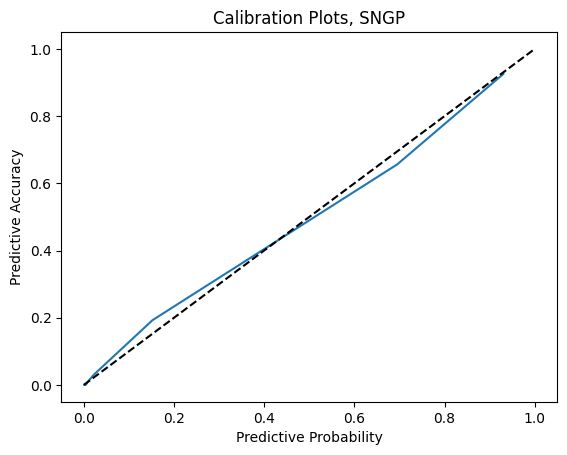

In [26]:
plt.plot(prob_pred, prob_true)

plt.plot([0., 1.], [0., 1.], c='k', linestyle="--")
plt.xlabel('Predictive Probability')
plt.ylabel('Predictive Accuracy')
plt.title('Calibration Plots, SNGP')

plt.show()

## Resources and further reading

* See the [SNGP tutorial](https://www.tensorflow.org/tutorials/understanding/sngp) for a detailed walkthrough of implementing SNGP from scratch. 
* See [Uncertainty Baselines](https://github.com/google/uncertainty-baselines)  for the implementation of SNGP model (and many other uncertainty methods) on a wide variety of benchmark datasets (e.g., [CIFAR](https://www.tensorflow.org/datasets/catalog/cifar100), [ImageNet](https://www.tensorflow.org/datasets/catalog/imagenet2012), [Jigsaw toxicity detection](https://www.tensorflow.org/datasets/catalog/wikipedia_toxicity_subtypes), etc).
* For a deeper understanding of the SNGP method, check out the paper [Simple and Principled Uncertainty Estimation with Deterministic Deep Learning via Distance Awareness](https://arxiv.org/abs/2006.10108).
